In [ ]:
#@title Imports
!pip install hmmlearn
import pandas   
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import os
import tqdm.notebook as tq
import PIL

from sklearn.model_selection import GridSearchCV  #gridsearch hyperparameter optimization stuff
from keras.wrappers.scikit_learn import KerasClassifier
%tensorflow_version 2.x

#Machine learning imports for CNNs:
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

if tf.__version__[:1] == '1.':
  Sequential = keras.layers.Sequential
else:
  Sequential = keras.models.Sequential

from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.layers import Activation, Dropout, Flatten, Dense
#import keras.layers.experimental.preprocessing as preprocessing

from sklearn.metrics import confusion_matrix

!pip install wget
import wget

downloaded_files = []


from keras.regularizers import l2

     |████████████████████████████████| 374 kB 8.9 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=5653a3869d211923be7e6a829c51ed7c598ed6642cdf688e4a6c74c6599330dc
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
!wget https://www.dropbox.com/s/xcgvi8je6l2bxj6/multiplexing_data__bg_constant__ke_10_10__ki_03_03__kdiff_0_55_0_55__time_3000__cells_100__spots_25_25.zip?dl=0
!unzip /content/multiplexing_data__bg_constant__ke_10_10__ki_03_03__kdiff_0_55_0_55__time_3000__cells_100__spots_25_25.zip?dl=0

--2021-10-01 16:38:12--  https://www.dropbox.com/s/xcgvi8je6l2bxj6/multiplexing_data__bg_constant__ke_10_10__ki_03_03__kdiff_0_55_0_55__time_3000__cells_100__spots_25_25.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xcgvi8je6l2bxj6/multiplexing_data__bg_constant__ke_10_10__ki_03_03__kdiff_0_55_0_55__time_3000__cells_100__spots_25_25.zip [following]
--2021-10-01 16:38:13--  https://www.dropbox.com/s/raw/xcgvi8je6l2bxj6/multiplexing_data__bg_constant__ke_10_10__ki_03_03__kdiff_0_55_0_55__time_3000__cells_100__spots_25_25.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc782032a225309badffd6b85c69.dl.dropboxusercontent.com/cd/0/inline/BXOPI-CqqqYaBo_zkkUziWlZeTKqTa9D2r58SooTRBIUPdbfDWIO1TiOA5HJS2cepWVLKydT

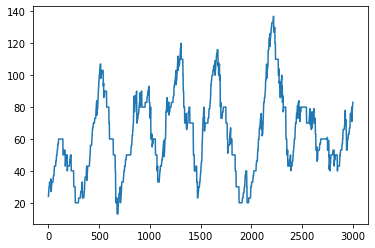

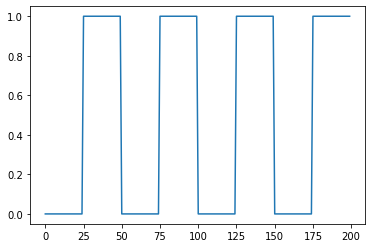

In [ ]:
#@title dataset setup
csv = '/content/multiplexing_data__bg_constant__ke_10_10__ki_03_03__kdiff_0_55_0_55__time_3000__cells_100__spots_25_25/multiplexing_csv.csv'
ssas = '/content/multiplexing_data__bg_constant__ke_10_10__ki_03_03__kdiff_0_55_0_55__time_3000__cells_100__spots_25_25/ssas_multiplexing.npy'


multiplexing_df = pandas.read_csv(csv)
multiplexing_df.head()
multiplexing_ssa = np.load(ssas)
ssa_time = multiplexing_ssa.shape[-1]
total_traj = np.prod(multiplexing_ssa.shape[:-1])
spot_nums = multiplexing_ssa.shape[2]


def convert_labels_to_onehot(labels):
    '''
    converts labels in the format 1xN, [0,0,1,2,3,...] to onehot encoding,
    ie: N_classes x N,  [[1,0,0,0],[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]     
    '''
    onehotlabels = np.zeros((labels.shape[0],len(np.unique(labels))))
    for i in range(len(onehotlabels)):
        onehotlabels[i,labels[i]] = 1
    return onehotlabels


plt.plot(multiplexing_ssa.reshape(total_traj,ssa_time)[60])

ssas = multiplexing_ssa.reshape(total_traj,ssa_time)
labels = np.zeros([total_traj,1])
label = 1
for i in range(total_traj):
  if i%spot_nums == 0:
    label = (label+1)%2
  labels[i] = label
plt.figure()
plt.plot(labels[0:200])
ssa_labels = labels.astype(int)

ssa_labels_onehot = convert_labels_to_onehot(ssa_labels)


def df_to_array(dataframe_simulated_cell):
  # get the total number of particles in all cells
  total_particles = 0
  for cell in set(dataframe_simulated_cell['cell_number']):
    total_particles += len(set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle'] ))

  #preallocate numpy array sof n_particles by nframes
  I_g = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] )  #intensity green
  I_g_std = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #intensity green std
  x_loc = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #x loc
  y_loc = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #y_loc
  I_r_std   = np.zeros([total_particles, (np.max(dataframe_simulated_cell['frame'])+1)] ) #intensity red
  I_r = np.zeros([total_particles, (np.max(dataframe_simulated_cell['frame'])+1) ] ) #intensity red std
  labels = np.zeros([total_particles])
  label_list = list(set(np.unique(dataframe_simulated_cell['Classification'])))
  k = 0
  for cell in set(dataframe_simulated_cell['cell_number']):  #for every cell 
    for particle in set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle'] ): #for every particle
      tmpdf = dataframe_simulated_cell[(dataframe_simulated_cell['cell_number'] == cell) & (dataframe_simulated_cell['particle'] == particle)]  #slice the dataframe
      maxframe = np.max(tmpdf['frame'])
      minframe = np.min(tmpdf['frame'])
      I_g[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_mean']  #fill the arrays to return out
      x_loc[k, 0:(maxframe+1-minframe)] = tmpdf['x']
      y_loc[k, 0:(maxframe+1-minframe)] = tmpdf['y']
      I_g_std[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_std']
      I_r[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_mean']
      I_r_std[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_std']
      labels[k] = label_list.index(list(set(np.unique(tmpdf['Classification'])))[0])

      k+=1 #iterate over k (total particles)
  return I_g, I_g_std, I_r, I_r_std, labels, x_loc,y_loc   #return everything backout

#intensitys, labels, and x y locations
int_g, int_g_std, int_r, int_r_std, labels, x_loc, y_loc = df_to_array(multiplexing_df)
t = np.linspace(0,len(int_g) - 1,len(int_g))  #time vector in seconds


labels_onehot = convert_labels_to_onehot(labels.astype(int))

X_time_series = np.expand_dims( np.array([int_g.T, x_loc.T,y_loc.T]).T, axis=-1)
Y_time_series = labels_onehot



In [ ]:
from scipy import signal

square_mu = .00014
square_cov = .00008

sawtooth_mu = .0002
sawtooth_cov = .00005

noise_mu = .4
noise_cov=.3

tri_mu = .0001
tri_cov = .0001

sine_amp = .5
sine_freq_mu = .00007
sine_freq_cov = .00007

def white_noise(t,mu,cov):
  return np.random.normal(mu, np.sqrt(cov), size=len(t))

def random_square(t, mu, cov):
  amp = np.random.normal(mu, np.sqrt(cov))
  return signal.square(2 * np.pi *amp * t)

def random_saw(t, mu, cov):
  amp = np.random.normal(mu, np.sqrt(cov))
  return signal.sawtooth(2 * np.pi *amp * t)

def random_sine(t,amp,freq_mu, freq_cov):
  f = np.random.normal(freq_mu, np.sqrt(freq_cov))
  return amp*np.sin( f*t )
  
def random_triangle(t,mu,cov):
  amp = np.random.normal(mu, np.sqrt(cov))
  return signal.sawtooth(2 * np.pi * amp * t, 0.5)

def normalize_signal(sig):
  return (sig - np.min(sig)) / (np.max(sig) - np.min(sig))

def make_signal_type_a(n_traj,t):
  X = np.zeros([n_traj, len(t)])
  for i in range(n_traj):
    sig = random_square(t,square_mu, square_cov) + random_saw(t,sawtooth_mu, sawtooth_cov) + white_noise(t,noise_mu,noise_mu )
    X[i] = normalize_signal(sig)
  return X


def make_signal_type_b(n_traj,t):
  X = np.zeros([n_traj, len(t)])
  for i in range(n_traj):
    sig = random_triangle(t,tri_mu, tri_cov) + random_sine(t,sine_amp,sine_freq_mu, sine_freq_cov) + white_noise(t,noise_mu,noise_mu )
    X[i] = normalize_signal(sig)
  return X


def make_signal_type_a_nonrandom(n_traj,t):
  
  X = np.zeros([n_traj, 3000])
  for i in range(n_traj):  
    offset_1 = np.random.randint(500)
    sig = 2*signal.square(2 * np.pi *.005 * t) + 3*signal.sawtooth(2 * np.pi *.002 * t) + white_noise(t,noise_mu,noise_mu )
    sig = sig[offset_1:offset_1+3000]
    X[i] = normalize_signal(sig)
  return X


def make_signal_type_b_nonrandom(n_traj,t):

  X = np.zeros([n_traj, 3000])
  for i in range(n_traj):
    offset_1 = np.random.randint(500)
    sig = signal.sawtooth(2 * np.pi * .005 * t, 0.5,) + 3*np.sin( .01*t ) + white_noise(t,noise_mu,noise_mu )
    sig = sig[offset_1:offset_1+3000]

    X[i] = normalize_signal(sig)
  return X



  
t = np.linspace(0,5999,6000)
Signal_A = make_signal_type_a_nonrandom(2500,t)
Signal_B = make_signal_type_b_nonrandom(2500,t)

X = np.vstack([Signal_A,Signal_B])
test_dataset = X

test_labels = np.zeros([5000])
test_labels[2500:] = 1

def convert_labels_to_onehot(labels):
    '''
    converts labels in the format 1xN, [0,0,1,2,3,...] to onehot encoding,
    ie: N_classes x N,  [[1,0,0,0],[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]     
    '''
    onehotlabels = np.zeros((labels.shape[0],len(np.unique(labels))))
    for i in range(len(onehotlabels)):
        onehotlabels[i,labels[i]] = 1
    return onehotlabels

test_labels_onehot = convert_labels_to_onehot(test_labels.astype(int))

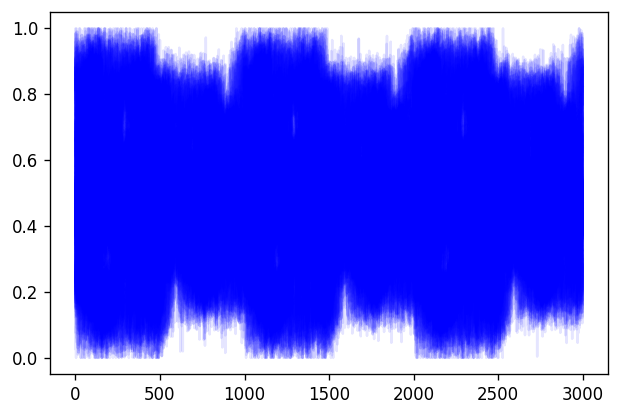

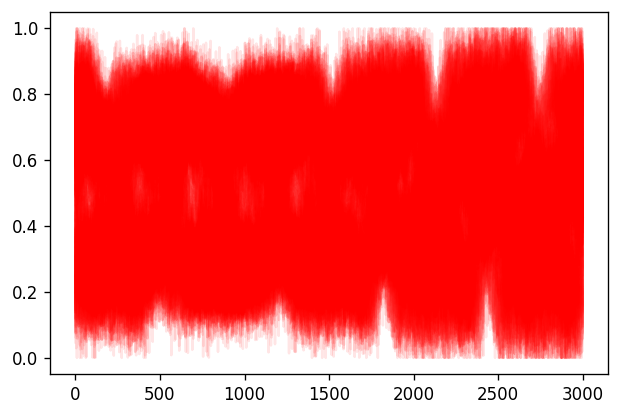

In [ ]:
plt.figure(dpi=120)
plt.plot(Signal_A[:200].T, 'b-',alpha=.1)
plt.figure(dpi=120)
plt.plot(Signal_B[:200].T, 'r-',alpha=.1)
print('')

In [ ]:
!pip install kymatio
!pip install tslearn

     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 793 kB 7.9 MB/s 


In [ ]:
#@title DTC clustering 
from keras.layers import Layer, InputSpec
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv1D, LeakyReLU, MaxPool1D, CuDNNLSTM, Bidirectional, TimeDistributed, Dense, Reshape
from keras.layers import UpSampling2D, Conv2DTranspose
import numpy as np
from sklearn import metrics
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import label_binarize
from statsmodels.tsa import stattools
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import os
import csv
import argparse
from time import time

# Keras
from keras.models import Model
from keras.layers import Dense, Reshape, UpSampling2D, Conv2DTranspose, GlobalAveragePooling1D, Softmax
from keras.losses import kullback_leibler_divergence
import keras.backend as K

# scikit-learn
from sklearn.cluster import AgglomerativeClustering, KMeans




def eucl(x, y):
    """
    Euclidean distance between two multivariate time series given as arrays of shape (timesteps, dim)
    """
    d = np.sqrt(np.sum(np.square(x - y), axis=0))
    return np.sum(d)


def cid(x, y):
    """
    Complexity-Invariant Distance (CID) between two multivariate time series given as arrays of shape (timesteps, dim)
    Reference: Batista, Wang & Keogh (2011). A Complexity-Invariant Distance Measure for Time Series. https://doi.org/10.1137/1.9781611972818.60
    """
    assert(len(x.shape) == 2 and x.shape == y.shape)  # time series must have same length and dimensionality
    ce_x = np.sqrt(np.sum(np.square(np.diff(x, axis=0)), axis=0) + 1e-9)
    ce_y = np.sqrt(np.sum(np.square(np.diff(y, axis=0)), axis=0) + 1e-9)
    d = np.sqrt(np.sum(np.square(x - y), axis=0)) * np.divide(np.maximum(ce_x, ce_y), np.minimum(ce_x, ce_y))
    return np.sum(d)


def cor(x, y):
    """
    Correlation-based distance (COR) between two multivariate time series given as arrays of shape (timesteps, dim)
    """
    scaler = TimeSeriesScalerMeanVariance()
    x_norm = scaler.fit_transform(x)
    y_norm = scaler.fit_transform(y)
    pcc = np.mean(x_norm * y_norm)  # Pearson correlation coefficients
    d = np.sqrt(2.0 * (1.0 - pcc + 1e-9))  # correlation-based similarities
    return np.sum(d)


def acf(x, y):
    """
    Autocorrelation-based distance (ACF) between two multivariate time series given as arrays of shape (timesteps, dim)
    Computes a linearly weighted euclidean distance between the autocorrelation coefficients of the input time series.
    Reference: Galeano & Pena (2000). Multivariate Analysis in Vector Time Series.
    """
    assert (len(x.shape) == 2 and x.shape == y.shape)  # time series must have same length and dimensionality
    x_acf = np.apply_along_axis(lambda z: stattools.acf(z, nlags=z.shape[0]), 0, x)
    y_acf = np.apply_along_axis(lambda z: stattools.acf(z, nlags=z.shape[0]), 0, y)
    weights = np.linspace(1.0, 0.0, x.shape[0])
    d = np.sqrt(np.sum(np.expand_dims(weights, axis=1) * np.square(x_acf - y_acf), axis=0))
    return np.sum(d)

def cluster_acc(y_true, y_pred):
    """
    Calculate unsupervised clustering accuracy. Requires scikit-learn installed
    # Arguments
        y_true: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return w[row_ind, col_ind].sum() * 1.0 / y_pred.size


def cluster_purity(y_true, y_pred):
    """
    Calculate clustering purity
    # Arguments
        y_true: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        purity, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    label_mapping = w.argmax(axis=1)
    y_pred_voted = y_pred.copy()
    for i in range(y_pred.size):
        y_pred_voted[i] = label_mapping[y_pred[i]]
    return metrics.accuracy_score(y_pred_voted, y_true)


def roc_auc(y_true, q_pred, n_classes):
    """
    Calculate area under ROC curve (ROC AUC)
    WARNING: DO NOT USE, MAY CONTAIN ERRORS
    TODO: CHECK IT!
    # Arguments
        y_true: true labels, numpy.array with shape `(n_samples,)`
        q_pred: predicted probabilities, numpy.array with shape `(n_samples,)`
    # Return
        ROC AUC score, in [0,1]
    """
    if n_classes == 2:  # binary ROC AUC
        auc = max(metrics.roc_auc_score(y_true, q_pred[:, 1]), metrics.roc_auc_score(y_true, q_pred[:, 0]))
    else:  # micro-averaged ROC AUC (multiclass)
        fpr, tpr, _ = metrics.roc_curve(label_binarize(y_true, classes=np.unique(y_true)).ravel(), q_pred.ravel())
        auc = metrics.auc(fpr, tpr)
    return auc

def temporal_autoencoder(input_dim, timesteps, n_filters=50, kernel_size=10, strides=1, pool_size=10, n_units=[50, 1]):
    """
    Temporal Autoencoder (TAE) model with Convolutional and BiLSTM layers.
    # Arguments
        input_dim: input dimension
        timesteps: number of timesteps (can be None for variable length sequences)
        n_filters: number of filters in convolutional layer
        kernel_size: size of kernel in convolutional layer
        strides: strides in convolutional layer
        pool_size: pooling size in max pooling layer, must divide time series length
        n_units: numbers of units in the two BiLSTM layers
        alpha: coefficient in Student's kernel
        dist_metric: distance metric between latent sequences
    # Return
        (ae_model, encoder_model, decoder_model): AE, encoder and decoder models
    """
    assert(timesteps % pool_size == 0)

    # Input
    x = Input(shape=(timesteps, input_dim), name='input_seq')

    # Encoder
    encoded = Conv1D(n_filters, kernel_size, strides=strides, padding='same', activation='linear')(x)
    encoded = LeakyReLU()(encoded)
    encoded = MaxPool1D(pool_size)(encoded)
    encoded = Bidirectional(CuDNNLSTM(n_units[0], return_sequences=True), merge_mode='sum')(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = Bidirectional(CuDNNLSTM(n_units[1], return_sequences=True), merge_mode='sum')(encoded)
    encoded = LeakyReLU(name='latent')(encoded)

    # Decoder
    decoded = Reshape((-1, 1, n_units[1]), name='reshape')(encoded)
    decoded = UpSampling2D((pool_size, 1), name='upsampling')(decoded)  #decoded = UpSampling1D(pool_size, name='upsampling')(decoded)
    decoded = Conv2DTranspose(input_dim, (kernel_size, 1), padding='same', name='conv2dtranspose')(decoded)
    output = Reshape((-1, input_dim), name='output_seq')(decoded)  #output = Conv1D(1, kernel_size, strides=strides, padding='same', activation='linear', name='output_seq')(decoded)

    # AE model
    autoencoder = Model(inputs=x, outputs=output, name='AE')

    # Encoder model
    encoder = Model(inputs=x, outputs=encoded, name='encoder')

    # Create input for decoder model
    encoded_input = Input(shape=(timesteps // pool_size, n_units[1]), name='decoder_input')

    # Internal layers in decoder
    decoded = autoencoder.get_layer('reshape')(encoded_input)
    decoded = autoencoder.get_layer('upsampling')(decoded)
    decoded = autoencoder.get_layer('conv2dtranspose')(decoded)
    decoder_output = autoencoder.get_layer('output_seq')(decoded)

    # Decoder model
    decoder = Model(inputs=encoded_input, outputs=decoder_output, name='decoder')

    return autoencoder, encoder, decoder


def temporal_autoencoder_v2(input_dim, timesteps, n_filters=50, kernel_size=10, strides=1, pool_size=10, n_units=[50, 1]):
    """
    Temporal Autoencoder (TAE) model with Convolutional and BiLSTM layers.
    # Arguments
        input_dim: input dimension
        timesteps: number of timesteps (can be None for variable length sequences)
        n_filters: number of filters in convolutional layer
        kernel_size: size of kernel in convolutional layer
        strides: strides in convolutional layer
        pool_size: pooling size in max pooling layer
        n_units: numbers of units in the two BiLSTM layers
        alpha: coefficient in Student's kernel
        dist_metric: distance metric between latent sequences
    # Return
        (ae_model, encoder_model, decoder_model): AE, encoder and decoder models
    """
    assert (timesteps % pool_size == 0)

    # Input
    x = Input(shape=(timesteps, input_dim), name='input_seq')

    # Encoder
    encoded = Conv1D(n_filters, kernel_size, strides=strides, padding='same', activation='linear')(x)
    encoded = LeakyReLU()(encoded)
    encoded = MaxPool1D(pool_size)(encoded)
    encoded = Bidirectional(CuDNNLSTM(n_units[0], return_sequences=True), merge_mode='concat')(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = Bidirectional(CuDNNLSTM(n_units[1], return_sequences=True), merge_mode='concat')(encoded)
    encoded = LeakyReLU(name='latent')(encoded)

    # Decoder
    decoded = TimeDistributed(Dense(units=n_filters), name='dense')(encoded)  # sequence labeling
    decoded = LeakyReLU(name='act')(decoded)
    decoded = Reshape((-1, 1, n_filters), name='reshape')(decoded)
    decoded = UpSampling2D((pool_size, 1), name='upsampling')(decoded)
    decoded = Conv2DTranspose(input_dim, (kernel_size, 1), padding='same', name='conv2dtranspose')(decoded)
    output = Reshape((-1, input_dim), name='output_seq')(decoded)

    # AE model
    autoencoder = Model(inputs=x, outputs=output, name='AE')

    # Encoder model
    encoder = Model(inputs=x, outputs=encoded, name='encoder')

    # Create input for decoder model
    encoded_input = Input(shape=(timesteps // pool_size, 2 * n_units[1]), name='decoder_input')
    # Internal layers in decoder
    decoded = autoencoder.get_layer('dense')(encoded_input)
    decoded = autoencoder.get_layer('act')(decoded)
    decoded = autoencoder.get_layer('reshape')(decoded)
    decoded = autoencoder.get_layer('upsampling')(decoded)
    decoded = autoencoder.get_layer('conv2dtranspose')(decoded)
    decoder_output = autoencoder.get_layer('output_seq')(decoded)

    # Decoder model
    decoder = Model(inputs=encoded_input, outputs=decoder_output, name='decoder')

    return autoencoder, encoder, decoder

class TSClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, timesteps, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
        dist_metric: distance metric between sequences used in similarity kernel ('eucl', 'cir', 'cor' or 'acf').
    # Input shape
        3D tensor with shape: `(n_samples, timesteps, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, dist_metric='eucl', **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(TSClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.dist_metric = dist_metric
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=3)
        self.clusters = None
        self.built = False

    def build(self, input_shape):
        assert len(input_shape) == 3
        input_dim = input_shape[2]
        input_steps = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_steps, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_steps, input_dim), initializer='glorot_uniform', name='cluster_centers')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """
        Student t-distribution kernel, probability of assigning encoded sequence i to cluster k.
            q_{ik} = (1 + dist(z_i, m_k)^2)^{-1} / normalization.
        Arguments:
            inputs: encoded input sequences, shape=(n_samples, timesteps, n_features)
        Return:
            q: soft labels for each sample. shape=(n_samples, n_clusters)
        """
        if self.dist_metric == 'eucl':
            distance = K.sum(K.sqrt(K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2)), axis=-1)
        elif self.dist_metric == 'cid':
            ce_x = K.sqrt(K.sum(K.square(inputs[:, 1:, :] - inputs[:, :-1, :]), axis=1))  # shape (n_samples, n_features)
            ce_w = K.sqrt(K.sum(K.square(self.clusters[:, 1:, :] - self.clusters[:, :-1, :]), axis=1))  # shape (n_clusters, n_features)
            ce = K.maximum(K.expand_dims(ce_x, axis=1), ce_w) / K.minimum(K.expand_dims(ce_x, axis=1), ce_w)  # shape (n_samples, n_clusters, n_features)
            ed = K.sqrt(K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2))  # shape (n_samples, n_clusters, n_features)
            distance = K.sum(ed * ce, axis=-1)  # shape (n_samples, n_clusters)
        elif self.dist_metric == 'cor':
            inputs_norm = (inputs - K.expand_dims(K.mean(inputs, axis=1), axis=1)) / K.expand_dims(K.std(inputs, axis=1), axis=1)  # shape (n_samples, timesteps, n_features)
            clusters_norm = (self.clusters - K.expand_dims(K.mean(self.clusters, axis=1), axis=1)) / K.expand_dims(K.std(self.clusters, axis=1), axis=1)  # shape (n_clusters, timesteps, n_features)
            pcc = K.mean(K.expand_dims(inputs_norm, axis=1) * clusters_norm, axis=2)  # Pearson correlation coefficients
            distance = K.sum(K.sqrt(2.0 * (1.0 - pcc)), axis=-1)  # correlation-based similarities, shape (n_samples, n_clusters)
        elif self.dist_metric == 'acf':
            raise NotImplementedError
        else:
            raise ValueError('Available distances are eucl, cid, cor and acf!')
        q = 1.0 / (1.0 + K.square(distance) / self.alpha)
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 3
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters, 'dist_metric': self.dist_metric}
        base_config = super(TSClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



class DTC:
    """
    Deep Temporal Clustering (DTC) model
    # Arguments
        n_clusters: number of clusters
        input_dim: input dimensionality
        timesteps: length of input sequences (can be None for variable length)
        n_filters: number of filters in convolutional layer
        kernel_size: size of kernel in convolutional layer
        strides: strides in convolutional layer
        pool_size: pooling size in max pooling layer, must divide the time series length
        n_units: numbers of units in the two BiLSTM layers
        alpha: coefficient in Student's kernel
        dist_metric: distance metric between latent sequences
        cluster_init: cluster initialization method
    """

    def __init__(self, n_clusters, input_dim, timesteps,
                 n_filters=50, kernel_size=10, strides=1, pool_size=10, n_units=[50, 1],
                 alpha=1.0, dist_metric='eucl', cluster_init='kmeans', heatmap=False):
        assert(timesteps % pool_size == 0)
        self.n_clusters = n_clusters
        self.input_dim = input_dim
        self.timesteps = timesteps
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.n_units = n_units
        self.latent_shape = (self.timesteps // self.pool_size, self.n_units[1])
        self.alpha = alpha
        self.dist_metric = dist_metric
        self.cluster_init = cluster_init
        self.heatmap = heatmap
        self.pretrained = False
        self.model = self.autoencoder = self.encoder = self.decoder = None
        if self.heatmap:
            self.heatmap_model = None
            self.heatmap_loss_weight = None
            self.initial_heatmap_loss_weight = None
            self.final_heatmap_loss_weight = None
            self.finetune_heatmap_at_epoch = None

    def initialize(self):
        """
        Create DTC model
        """
        # Create AE models
        self.autoencoder, self.encoder, self.decoder = temporal_autoencoder(input_dim=self.input_dim,
                                                                            timesteps=self.timesteps,
                                                                            n_filters=self.n_filters,
                                                                            kernel_size=self.kernel_size,
                                                                            strides=self.strides,
                                                                            pool_size=self.pool_size,
                                                                            n_units=self.n_units)
        clustering_layer = TSClusteringLayer(self.n_clusters,
                                             alpha=self.alpha,
                                             dist_metric=self.dist_metric,
                                             name='TSClustering')(self.encoder.output)

        # Heatmap-generating network
        if self.heatmap:
            n_heatmap_filters = self.n_clusters  # one heatmap (class activation map) per cluster
            encoded = self.encoder.output
            heatmap_layer = Reshape((-1, 1, self.n_units[1]))(encoded)
            heatmap_layer = UpSampling2D((self.pool_size, 1))(heatmap_layer)
            heatmap_layer = Conv2DTranspose(n_heatmap_filters, (self.kernel_size, 1), padding='same')(heatmap_layer)
            # The next one is the heatmap layer we will visualize
            heatmap_layer = Reshape((-1, n_heatmap_filters), name='Heatmap')(heatmap_layer)
            heatmap_output_layer = GlobalAveragePooling1D()(heatmap_layer)
            # A dense layer must be added only if `n_heatmap_filters` is different from `n_clusters`
            # heatmap_output_layer = Dense(self.n_clusters, activation='relu')(heatmap_output_layer)
            heatmap_output_layer = Softmax()(heatmap_output_layer)  # normalize activations with softmax

        if self.heatmap:
            # Create DTC model
            self.model = Model(inputs=self.autoencoder.input,
                               outputs=[self.autoencoder.output, clustering_layer, heatmap_output_layer])
            # Create Heatmap model
            self.heatmap_model = Model(inputs=self.autoencoder.input,
                                       outputs=heatmap_layer)
        else:
            # Create DTC model
            self.model = Model(inputs=self.autoencoder.input,
                               outputs=[self.autoencoder.output, clustering_layer])

    @property
    def cluster_centers_(self):
        """
        Returns cluster centers
        """
        return self.model.get_layer(name='TSClustering').get_weights()[0]

    @staticmethod
    def weighted_kld(loss_weight):
        """
        Custom KL-divergence loss with a variable weight parameter
        """
        def loss(y_true, y_pred):
            return loss_weight * kullback_leibler_divergence(y_true, y_pred)
        return loss

    def on_epoch_end(self, epoch):
        """
        Update heatmap loss weight on epoch end
        """
        if epoch > self.finetune_heatmap_at_epoch:
            K.set_value(self.heatmap_loss_weight, self.final_heatmap_loss_weight)

    def compile(self, gamma, optimizer, initial_heatmap_loss_weight=None, final_heatmap_loss_weight=None):
        """
        Compile DTC model
        # Arguments
            gamma: coefficient of TS clustering loss
            optimizer: optimization algorithm
            initial_heatmap_loss_weight (optional): initial weight of heatmap loss vs clustering loss
            final_heatmap_loss_weight (optional): final weight of heatmap loss vs clustering loss (heatmap finetuning)
        """
        if self.heatmap:
            self.initial_heatmap_loss_weight = initial_heatmap_loss_weight
            self.final_heatmap_loss_weight = final_heatmap_loss_weight
            self.heatmap_loss_weight = K.variable(self.initial_heatmap_loss_weight)
            self.model.compile(loss=['mse', DTC.weighted_kld(1.0 - self.heatmap_loss_weight), DTC.weighted_kld(self.heatmap_loss_weight)],
                               loss_weights=[1.0, gamma, gamma],
                               optimizer=optimizer)
        else:
            self.model.compile(loss=['mse', 'kld'],
                               loss_weights=[1.0, gamma],
                               optimizer=optimizer)

    def load_weights(self, weights_path):
        """
        Load pre-trained weights of DTC model
        # Arguments
            weight_path: path to weights file (.h5)
        """
        self.model.load_weights(weights_path)
        self.pretrained = True

    def load_ae_weights(self, ae_weights_path):
        """
        Load pre-trained weights of AE
        # Arguments
            ae_weight_path: path to weights file (.h5)
        """
        self.autoencoder.load_weights(ae_weights_path)
        self.pretrained = True

    def dist(self, x1, x2):
        """
        Compute distance between two multivariate time series using chosen distance metric
        # Arguments
            x1: first input (np array)
            x2: second input (np array)
        # Return
            distance
        """
        if self.dist_metric == 'eucl':
            return tsdistances.eucl(x1, x2)
        elif self.dist_metric == 'cid':
            return tsdistances.cid(x1, x2)
        elif self.dist_metric == 'cor':
            return tsdistances.cor(x1, x2)
        elif self.dist_metric == 'acf':
            return tsdistances.acf(x1, x2)
        else:
            raise ValueError('Available distances are eucl, cid, cor and acf!')

    def init_cluster_weights(self, X):
        """
        Initialize with complete-linkage hierarchical clustering or k-means.
        # Arguments
            X: numpy array containing training set or batch
        """
        assert(self.cluster_init in ['hierarchical', 'kmeans'])
        print('Initializing cluster...')

        features = self.encode(X)

        if self.cluster_init == 'hierarchical':
            if self.dist_metric == 'eucl':  # use AgglomerativeClustering off-the-shelf
                hc = AgglomerativeClustering(n_clusters=self.n_clusters,
                                             affinity='euclidean',
                                             linkage='complete').fit(features.reshape(features.shape[0], -1))
            else:  # compute distance matrix using dist
                d = np.zeros((features.shape[0], features.shape[0]))
                for i in range(features.shape[0]):
                    for j in range(i):
                        d[i, j] = d[j, i] = self.dist(features[i], features[j])
                hc = AgglomerativeClustering(n_clusters=self.n_clusters,
                                             affinity='precomputed',
                                             linkage='complete').fit(d)
            # compute centroid
            cluster_centers = np.array([features[hc.labels_ == c].mean(axis=0) for c in range(self.n_clusters)])
        elif self.cluster_init == 'kmeans':
            # fit k-means on flattened features
            km = KMeans(n_clusters=self.n_clusters, n_init=10).fit(features.reshape(features.shape[0], -1))
            cluster_centers = km.cluster_centers_.reshape(self.n_clusters, features.shape[1], features.shape[2])

        self.model.get_layer(name='TSClustering').set_weights([cluster_centers])
        print('Done!')

    def encode(self, x):
        """
        Encoding function. Extract latent features from hidden layer
        # Arguments
            x: data point
        # Return
            encoded (latent) data point
        """
        return self.encoder.predict(x)

    def decode(self, x):
        """
        Decoding function. Decodes encoded sequence from latent space.
        # Arguments
            x: encoded (latent) data point
        # Return
            decoded data point
        """
        return self.decoder.predict(x)

    def predict(self, x):
        """
        Predict cluster assignment.
        """
        q = self.model.predict(x, verbose=0)[1]
        return q.argmax(axis=1)

    @staticmethod
    def target_distribution(q):  # target distribution p which enhances the discrimination of soft label q
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def predict_heatmap(self, x):
        """
        Produces TS clustering heatmap from input sequence.
        # Arguments
            x: data point
        # Return
            heatmap
        """
        return self.heatmap_model.predict(x, verbose=0)

    def pretrain(self, X,
                 optimizer='adam',
                 epochs=10,
                 batch_size=64,
                 save_dir='results/tmp',
                 verbose=1):
        """
        Pre-train the autoencoder using only MSE reconstruction loss
        Saves weights in h5 format.
        # Arguments
            X: training set
            optimizer: optimization algorithm
            epochs: number of pre-training epochs
            batch_size: training batch size
            save_dir: path to existing directory where weights will be saved
        """
        print('Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        # Begin pretraining
        t0 = time()
        self.autoencoder.fit(X, X, batch_size=batch_size, epochs=epochs, verbose=verbose)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights('{}/ae_weights-epoch{}.h5'.format(save_dir, epochs))
        print('Pretrained weights are saved to {}/ae_weights-epoch{}.h5'.format(save_dir, epochs))
        self.pretrained = True

    def fit(self, X_train, y_train=None,
            X_val=None, y_val=None,
            epochs=100,
            eval_epochs=10,
            save_epochs=10,
            batch_size=64,
            tol=0.001,
            patience=5,
            finetune_heatmap_at_epoch=8,
            save_dir='results/tmp'):
        """
        Training procedure
        # Arguments
           X_train: training set
           y_train: (optional) training labels
           X_val: (optional) validation set
           y_val: (optional) validation labels
           epochs: number of training epochs
           eval_epochs: evaluate metrics on train/val set every eval_epochs epochs
           save_epochs: save model weights every save_epochs epochs
           batch_size: training batch size
           tol: tolerance for stopping criterion
           patience: patience for stopping criterion
           finetune_heatmap_at_epoch: epoch number where heatmap finetuning will start. Heatmap loss weight will
                                      switch from `self.initial_heatmap_loss_weight` to `self.final_heatmap_loss_weight`
           save_dir: path to existing directory where weights and logs are saved
        """
        if not self.pretrained:
            print('Autoencoder was not pre-trained!')

        if self.heatmap:
            self.finetune_heatmap_at_epoch = finetune_heatmap_at_epoch

        # Logging file
        logfile = open(save_dir + '/dtc_log.csv', 'w')
        fieldnames = ['epoch', 'T', 'L', 'Lr', 'Lc']
        if X_val is not None:
            fieldnames += ['L_val', 'Lr_val', 'Lc_val']
        if y_train is not None:
            fieldnames += ['acc', 'pur', 'nmi', 'ari']
        if y_val is not None:
            fieldnames += ['acc_val', 'pur_val', 'nmi_val', 'ari_val']
        logwriter = csv.DictWriter(logfile, fieldnames)
        logwriter.writeheader()

        y_pred_last = None
        patience_cnt = 0

        print('Training for {} epochs.\nEvaluating every {} and saving model every {} epochs.'.format(epochs, eval_epochs, save_epochs))

        for epoch in range(epochs):

            # Compute cluster assignments for training set
            q = self.model.predict(X_train)[1]
            p = DTC.target_distribution(q)

            # Evaluate losses and metrics on training set
            if epoch % eval_epochs == 0:

                # Initialize log dictionary
                logdict = dict(epoch=epoch)

                y_pred = q.argmax(axis=1)
                if X_val is not None:
                    q_val = self.model.predict(X_val)[1]
                    p_val = DTC.target_distribution(q_val)
                    y_val_pred = q_val.argmax(axis=1)

                print('epoch {}'.format(epoch))
                if self.heatmap:
                    loss = self.model.evaluate(X_train, [X_train, p, p], batch_size=batch_size, verbose=False)
                else:
                    loss = self.model.evaluate(X_train, [X_train, p], batch_size=batch_size, verbose=False)
                logdict['L'] = loss[0]
                logdict['Lr'] = loss[1]
                logdict['Lc'] = loss[2]
                print('[Train] - Lr={:f}, Lc={:f} - total loss={:f}'.format(logdict['Lr'], logdict['Lc'], logdict['L']))
                if X_val is not None:
                    val_loss = self.model.evaluate(X_val, [X_val, p_val], batch_size=batch_size, verbose=False)
                    logdict['L_val'] = val_loss[0]
                    logdict['Lr_val'] = val_loss[1]
                    logdict['Lc_val'] = val_loss[2]
                    print('[Val] - Lr={:f}, Lc={:f} - total loss={:f}'.format(logdict['Lr_val'], logdict['Lc_val'], logdict['L_val']))

                # Evaluate the clustering performance using labels
                if y_train is not None:
                    logdict['acc'] = cluster_acc(y_train, y_pred)
                    logdict['pur'] = cluster_purity(y_train, y_pred)
                    logdict['nmi'] = metrics.normalized_mutual_info_score(y_train, y_pred)
                    logdict['ari'] = metrics.adjusted_rand_score(y_train, y_pred)
                    print('[Train] - Acc={:f}, Pur={:f}, NMI={:f}, ARI={:f}'.format(logdict['acc'], logdict['pur'],
                                                                                    logdict['nmi'], logdict['ari']))
                if y_val is not None:
                    logdict['acc_val'] = cluster_acc(y_val, y_val_pred)
                    logdict['pur_val'] = cluster_purity(y_val, y_val_pred)
                    logdict['nmi_val'] = metrics.normalized_mutual_info_score(y_val, y_val_pred)
                    logdict['ari_val'] = metrics.adjusted_rand_score(y_val, y_val_pred)
                    print('[Val] - Acc={:f}, Pur={:f}, NMI={:f}, ARI={:f}'.format(logdict['acc_val'], logdict['pur_val'],
                                                                                  logdict['nmi_val'], logdict['ari_val']))

                logwriter.writerow(logdict)

                # check stop criterion
                if y_pred_last is not None:
                    assignment_changes = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = y_pred
                if epoch > 0 and assignment_changes < tol:
                    patience_cnt += 1
                    print('Assignment changes {} < {} tolerance threshold. Patience: {}/{}.'.format(assignment_changes, tol, patience_cnt, patience))
                    if patience_cnt >= patience:
                        print('Reached max patience. Stopping training.')
                        logfile.close()
                        break
                else:
                    patience_cnt = 0

            # Save intermediate model and plots
            if epoch % save_epochs == 0:
                self.model.save_weights(save_dir + '/DTC_model_' + str(epoch) + '.h5')
                print('Saved model to:', save_dir + '/DTC_model_' + str(epoch) + '.h5')

            # Train for one epoch
            if self.heatmap:
                self.model.fit(X_train, [X_train, p, p], epochs=1, batch_size=batch_size, verbose=False)
                self.on_epoch_end(epoch)
            else:
                self.model.fit(X_train, [X_train, p], epochs=1, batch_size=batch_size, verbose=False)

        # Save the final model
        logfile.close()
        print('Saving model to:', save_dir + '/DTC_model_final.h5')
        self.model.save_weights(save_dir + '/DTC_model_final.h5')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def standardize_signal(signal, axis = 0):
  return (signal - np.mean(signal, axis=axis)) / np.std(signal,axis=axis)

def normalize_signal(signal, axis = 0):
  return (signal -  np.min(signal,axis=axis) ) / ( np.max(signal,axis=axis)  - np.min(signal,axis=axis) )


def standardize_signal_global(signal, axis = 0):
  return (signal - np.mean(signal)) / np.std(signal)

def normalize_signal_global(signal, axis = 0):
  return (signal -  np.min(signal) ) / ( np.max(signal)  - np.min(signal) )


def displacement_signal(signal,axis=0):
  new_signal = np.zeros(signal.shape)
  new_signal[:,1:] = signal[:,:-1] - signal[:,1:]
  return new_signal

int_g_normalized= normalize_signal_global(int_g.T).T
#int_g_denoised_normalized= standardize_signal_global(int_g_denoised.T).T
ssas_normalized = normalize_signal(ssas.T).T

In [ ]:
#@title build feature set

input = int_g

def get_autocorrelation(data, g0='G0',norm='individual'):
  n_traj = data.shape[0]
  acf_vec = np.zeros(data.shape) 

  def get_acc_fft(signal):
    N = len(signal)
    fvi = np.fft.fft(signal, n=2*N)
    acf = fvi*np.conjugate(fvi)
    acf = np.fft.ifft(acf)
    acf = np.real(acf[:N])/float(N) 
    return acf
  global_mean = np.mean(data)
  global_var = np.var(data)
  for i in range(n_traj):
    if norm == 'individual':
      signal = (data[i] - np.mean(data[i]) )/ np.var(data[i])
    else: 
      signal = (data[i] - global_mean )/ global_var
    if g0 == 'G1':
      g1 = get_acc_fft(signal)[1]
      acf_vec[i] = get_acc_fft(signal.T)/g1 
    if g0 == 'G0':
      g = get_acc_fft(signal)[0]
      acf_vec[i] = get_acc_fft(signal.T)/g 
  return acf_vec


mean_int_G = np.mean(input,axis=1)
var_int_G = np.var(input,axis=1)
std_int_G = np.std(input,axis=1)
acf_green = get_autocorrelation(input)

taus = []
for i in range(len(acf_green)):
  taus.append(np.where(acf_green[i] <.05)[0][0])
green_decorr_times = np.array(taus)


include_mean = True #@param {type:"boolean"}
include_var = False #@param {type:"boolean"}
include_std = True #@param {type:"boolean"}
include_decorr_time = True #@param {type:"boolean"}

X = np.array([mean_int_G, std_int_G, var_int_G, taus])[np.array([include_mean,include_std,include_var,include_decorr_time  ])]
y = labels
print('Feature set size:')
print(X.shape)


Feature set size:
(3, 5000)


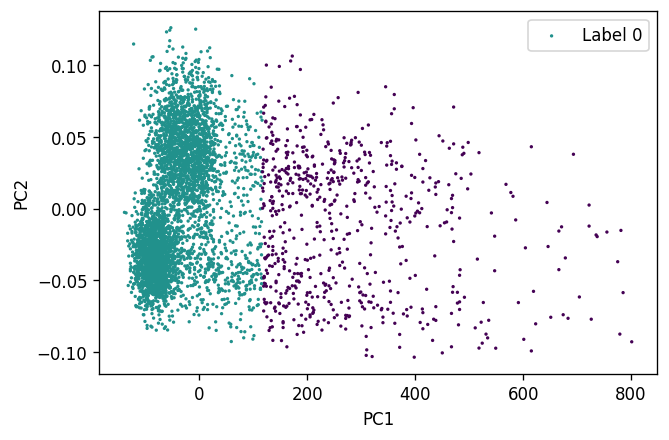

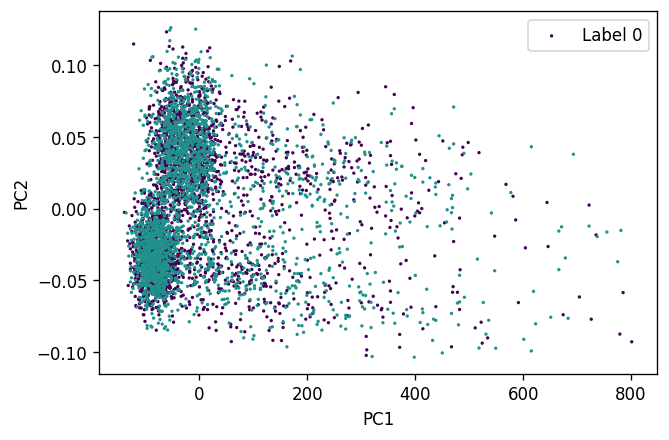

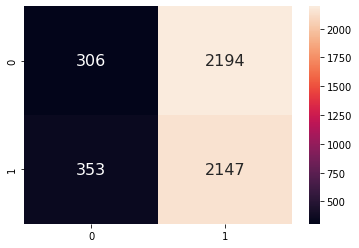

In [ ]:
#@title Kmeans
tmp_labels = np.zeros([5000])
tmp_labels[2500:] = 1
plot_labels = tmp_labels

n_clust = 2

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sn
km = KMeans(n_clusters=n_clust, random_state=0)
kmm_labels = km.fit_predict(X.T)

pca = PCA(n_components=2, svd_solver='full')
pca.fit(X.T)

latent_pca = pca.transform(X.T)


c = cm.viridis(np.abs(kmm_labels)*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])


c = cm.viridis(plot_labels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])


plt.figure()
conf = confusion_matrix(plot_labels.flatten(),np.abs(kmm_labels ))
cdf = pd.DataFrame(conf, range(n_clust),range(n_clust))

sn.heatmap(cdf, annot=True, annot_kws={"size": 16},fmt='g') # font size


[0.8922132  0.06455174 0.04323506]


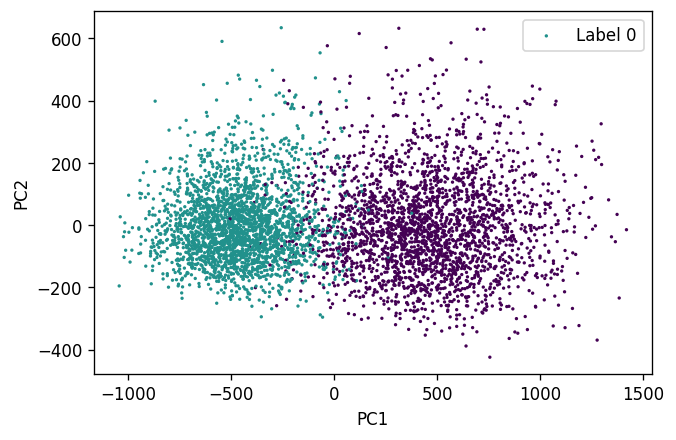

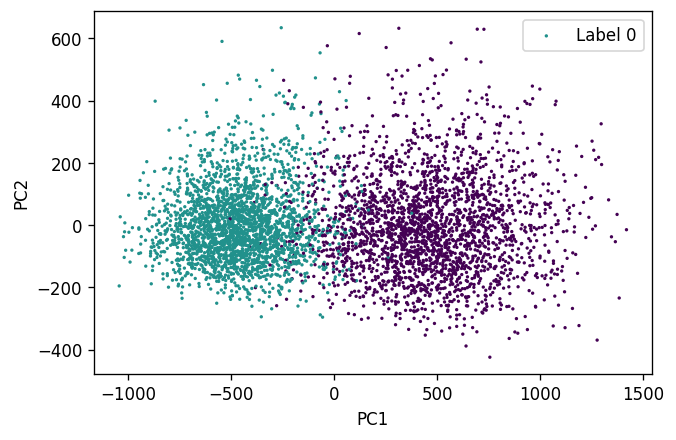

In [ ]:
#@title PCA


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sn

use_testing_dataset = False #@param {type:"boolean"}
if use_testing_dataset: 
  X_in = test_dataset
else:
  X_in = X.T

if use_testing_dataset:
  tmp_labels = np.zeros([5000])
  tmp_labels[2500:] = 1
  plot_labels = tmp_labels
else:
  plot_labels = labels


pca = PCA(n_components=3, svd_solver='full')
pca.fit(X_in)

latent_pca = pca.transform(X_in)
print(pca.explained_variance_ratio_)


c = cm.viridis(np.abs(plot_labels)*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])


c = cm.viridis(plot_labels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])




In [ ]:
kmm_labels

array([0, 1, 1], dtype=int32)

In [ ]:
from kymatio.keras import Scattering1D
from kymatio.datasets import fetch_fsdd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import mixture
from matplotlib import cm

J = 6
Q = 100
T = 3000
print(1 + J*Q + J*(J-1)*Q/2 )

x_in = keras.layers.Input(shape=(T))
x = Scattering1D(J, Q=Q)(x_in)
x = keras.layers.Lambda(lambda x: x[..., 1:, :])(x)
log_eps = 1e-6
x = keras.layers.Lambda(lambda x: tf.math.log(tf.abs(x) + log_eps))(x)
x = keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
x_out = keras.layers.BatchNormalization(axis=1)(x)

scatter1D_normal = tf.keras.models.Model(x_in, x_out)


2101.0


In [ ]:
!mkdir tmpdtc

In [ ]:
#DTC parameters
ae_weights = None
n_clusters=2
n_filters = 50
kernel_size = 30
strides  =1
pool_size=10
n_units = [50,1]
gamma = 1
alpha = 1
dist_metric = 'eucl'
cluster_init = 'kmeans'
heatmap= False
pretrain_epochs = 10
epochs=25
eval_epochs = 1
save_epochs = 10
batch_size = 64
tol = .001
patience = 5
finetune_heatmap_at_epoch = 8
initial_heatmap_loss_weight = 0.1
final_heatmap_loss_weight = .9
save_dir = '/content/tmpdtc/'

tmp_labels = np.zeros([5000])
tmp_labels[2500:] = 1

X_train, X_val, y_train, y_val = train_test_split(np.expand_dims(test_dataset,-1),tmp_labels,test_size=.2,random_state=42)
#(X_train, y_train), (X_val, y_val) = load_data(args.dataset), (None, None)
pretrain_optimizer = 'adam'

# Instantiate model
dtc = DTC(n_clusters=n_clusters,
          input_dim=X_train.shape[-1],
          timesteps=X_train.shape[1],
          n_filters=n_filters,
          kernel_size=kernel_size,
          strides=strides,
          pool_size=pool_size,
          n_units=n_units,
          alpha=alpha,
          dist_metric=dist_metric,
          cluster_init=cluster_init,
          heatmap=heatmap)

# Initialize model
optimizer = 'adam'
dtc.initialize()
dtc.model.summary()
dtc.compile(gamma=gamma, optimizer=optimizer, initial_heatmap_loss_weight=initial_heatmap_loss_weight,
            final_heatmap_loss_weight=final_heatmap_loss_weight)

if ae_weights is None and pretrain_epochs > 0:
    dtc.pretrain(X=X_train, optimizer=pretrain_optimizer,
                  epochs=pretrain_epochs, batch_size=batch_size,
                  save_dir=save_dir)
elif ae_weights is not None:
    dtc.load_ae_weights(ae_weights)

# Initialize clusters
dtc.init_cluster_weights(X_train)

# Fit model
t0 = time()
dtc.fit(X_train, y_train, X_val, y_val,epochs, eval_epochs, save_epochs, batch_size,
        tol, patience,finetune_heatmap_at_epoch, save_dir)
print('Training time: ', (time() - t0))

print('Performance (TRAIN)')
results = {}
q = dtc.model.predict(X_train)[1]
y_pred = q.argmax(axis=1)
if y_train is not None:
    results['acc'] = cluster_acc(y_train, y_pred)
    results['pur'] = cluster_purity(y_train, y_pred)
    results['nmi'] = metrics.normalized_mutual_info_score(y_train, y_pred)
    results['ari'] = metrics.adjusted_rand_score(y_train, y_pred)
print(results)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq (InputLayer)          [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 3000, 50)     1550        input_seq[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 3000, 50)     0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 300, 50)      0           leaky_re_lu_4[0][0]              
____________________________________________________________________________________________

[[1393 1107]
 [1546  954]]
0.4694


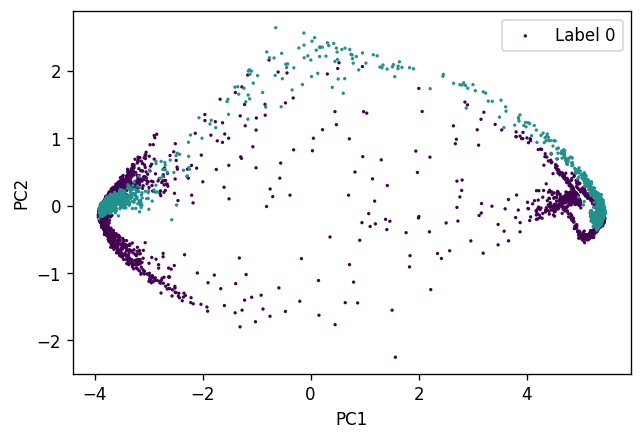

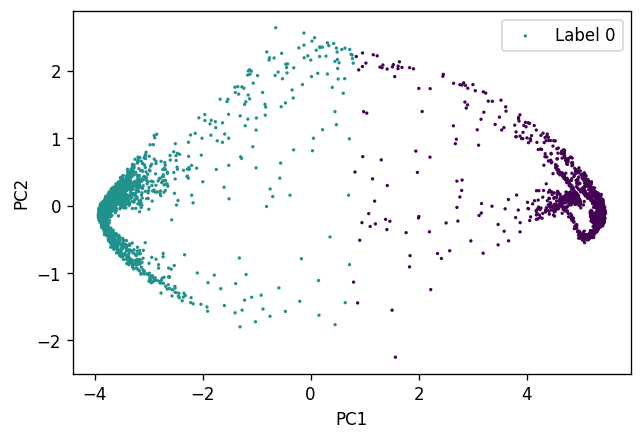

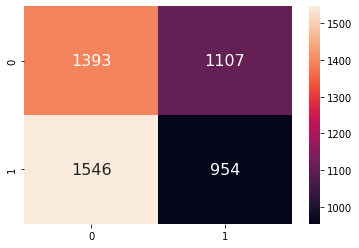

In [ ]:


tmp_labels = np.zeros([5000])
tmp_labels[2500:] = 1


plot_labels = tmp_labels
x_latent = dtc.encode(np.expand_dims(test_dataset,-1))
pca = PCA(n_components=2, svd_solver='full')
pca.fit(x_latent[:,:,0])
latent_pca = pca.transform(x_latent[:,:,0])


q = dtc.model.predict(np.expand_dims(test_dataset,-1))[1]
dtc_labels = q.argmax(axis=1)



c = cm.viridis(plot_labels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])



c = cm.viridis(np.abs(dtc_labels-1)*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])

from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
plt.figure()
conf = confusion_matrix(plot_labels.flatten(),np.abs(dtc_labels ))
cdf = pd.DataFrame(conf, range(2),range(2))

sn.heatmap(cdf, annot=True, annot_kws={"size": 16},fmt='g') # font size
print(confusion_matrix(plot_labels.flatten(),np.abs(dtc_labels )))
print(accuracy_score(plot_labels.flatten(),np.abs(dtc_labels)) )



[[1044 1456]
 [1998  502]]
0.3092


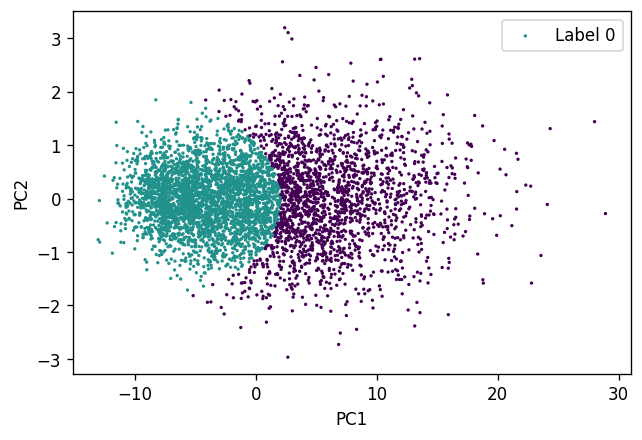

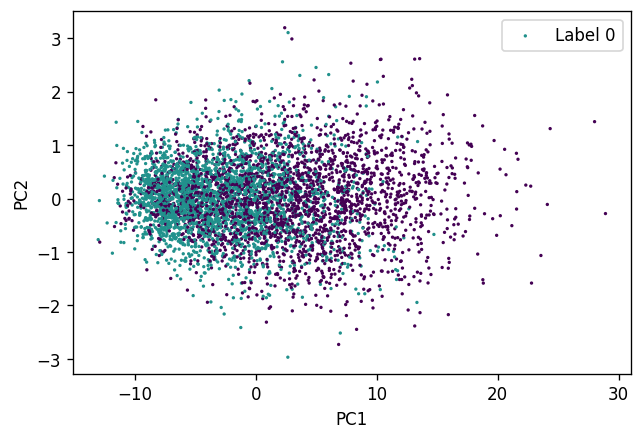

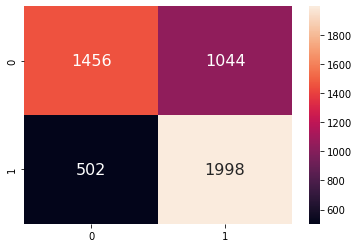

In [ ]:

J = 8
Q = 50
T = 3000

x_in = keras.layers.Input(shape=(T))
x = Scattering1D(J, Q=Q)(x_in)
x = keras.layers.Lambda(lambda x: x[..., 1:, :])(x)
log_eps = 1e-6
x = keras.layers.Lambda(lambda x: tf.math.log(tf.abs(x) + log_eps))(x)
x = keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
x_out = keras.layers.BatchNormalization(axis=1)(x)


x_train, x_val, label_train, label_val = train_test_split(int_g,labels,test_size=.2,random_state=42)

plot_labels = labels

scatter_coeff = scatter1D_normal(int_g)
scatter_coeff.shape

pca = PCA(n_components=2, svd_solver='full')
pca.fit(scatter_coeff.numpy())

latent_pca = pca.transform(scatter_coeff.numpy())
#latent_pca_val = pca.transform(latents_val)

#GMM
gmm = mixture.GaussianMixture(n_components=2,
                              covariance_type='full')
gmm.fit(scatter_coeff.numpy())
#gmmlabels = gmm.fit_predict(latent_pca_val)

gmmlabels = gmm.fit_predict(latent_pca)



print(confusion_matrix(plot_labels.flatten(),gmmlabels))
print(accuracy_score(plot_labels.flatten(),gmmlabels))


c = cm.viridis(np.abs(gmmlabels-1)*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])


c = cm.viridis(plot_labels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])


plt.figure()
conf = confusion_matrix(plot_labels.flatten(),np.abs(gmmlabels-1 ))
cdf = pd.DataFrame(conf, range(2),range(2))

sn.heatmap(cdf, annot=True, annot_kws={"size": 16},fmt='g') # font size

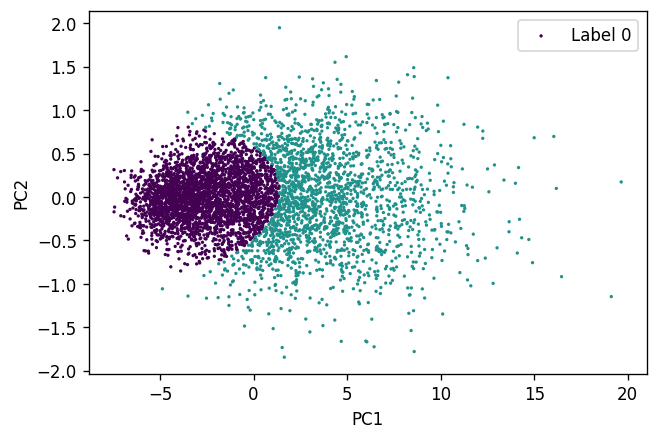

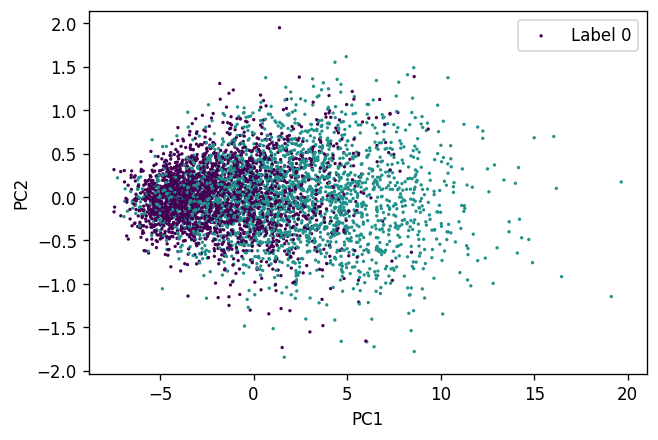

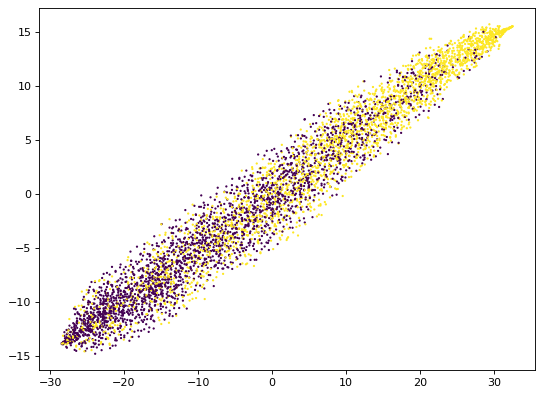

In [ ]:

c = cm.viridis(gmmlabels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])


c = cm.viridis(labels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca[:,0],latent_pca[:,1],c=c,s=1 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])


coeffs_embedded = TSNE(n_components=2, perplexity=90).fit_transform(scatter_coeff.numpy())
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coeffs_embedded[:, 0], coeffs_embedded[:, 1], c= labels,s=1)
plt.show()

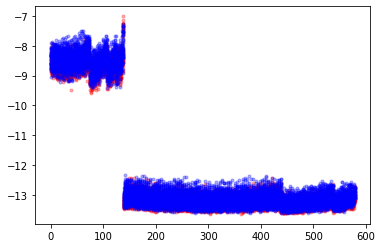

In [ ]:
scs = scatter_coeff.numpy()

plt.plot(scs[ labels == 0][0:20,:].T,'r.',alpha=.3)
plt.plot(scs[ labels == 1][0:20,:].T,'b.',alpha=.3)


In [ ]:
!git clone https://github.com/FlorentF9/DeepTemporalClustering
!python -m pip install tslearn

fatal: destination path 'DeepTemporalClustering' already exists and is not an empty directory.
     |████████████████████████████████| 793 kB 14.3 MB/s 


In [ ]:
!python ./DeepTemporalClustering/DeepTemporalClustering.py --help

Traceback (most recent call last):
  File "./DeepTemporalClustering/DeepTemporalClustering.py", line 27, in <module>
    from TSClusteringLayer import TSClusteringLayer
  File "/content/DeepTemporalClustering/TSClusteringLayer.py", line 8, in <module>
    from keras.engine.topology import Layer, InputSpec
ModuleNotFoundError: No module named 'keras.engine.topology'


## t-SNE

[[ 100 2400]
 [2386  114]]
0.0428


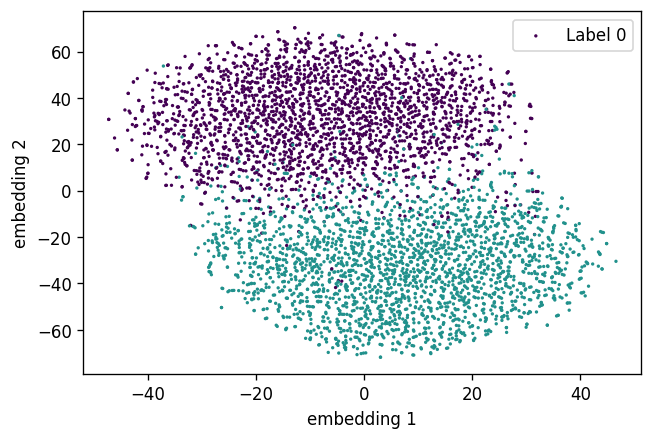

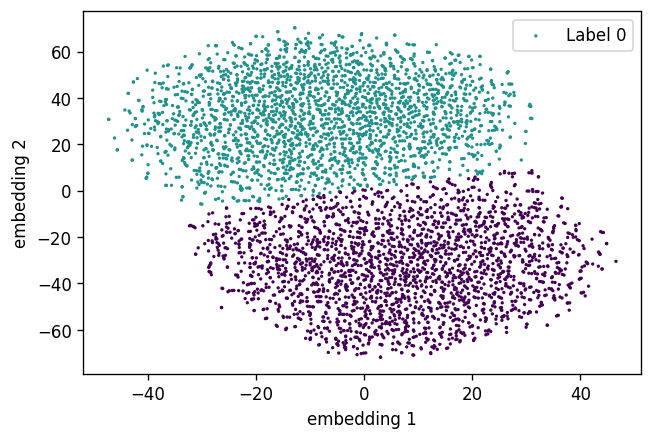

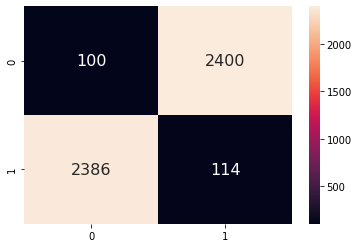

In [ ]:
from sklearn.manifold import TSNE
use_testing_dataset = False #@param {type:"boolean"}
if use_testing_dataset: 
  X_in = test_dataset
else:
  X_in = int_g_normalized
tsne_model = TSNE()
embedding = tsne_model.fit_transform(X_in)

if use_testing_dataset:
  tmp_labels = np.zeros([5000])
  tmp_labels[2500:] = 1
  plot_labels = tmp_labels
else:
  plot_labels = labels


c = cm.viridis(plot_labels*.5)
plt.figure(dpi=120)
plt.scatter(embedding[:,0],embedding[:,1],c=c,s=1,alpha=1)
plt.xlabel('embedding 1')
plt.ylabel('embedding 2')
plt.legend(['Label 0', 'Label 1'])

from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=2,
                              covariance_type='full')
gmmlabels = gmm.fit_predict(embedding)

from sklearn.metrics import accuracy_score, confusion_matrix

c = cm.viridis(gmmlabels*.5)
plt.figure(dpi=120)
plt.scatter(embedding[:,0],embedding[:,1],c=c,s=1 )
plt.xlabel('embedding 1')
plt.ylabel('embedding 2')
plt.legend(['Label 0', 'Label 1'])

print(confusion_matrix(plot_labels.flatten(),gmmlabels))
print(accuracy_score(plot_labels.flatten(),gmmlabels))

plt.figure()
conf = confusion_matrix(plot_labels.flatten(),np.abs(gmmlabels ))
cdf = pd.DataFrame(conf, range(2),range(2))

sn.heatmap(cdf, annot=True, annot_kws={"size": 16},fmt='g') # font size

## NL-AE only

In [ ]:
#@title Denoising Autoencoder

Denoise_dataset = False #@param {type:"boolean"}
use_testing_dataset = True #@param {type:"boolean"}
total_encoding_layers = 2 #@param slider {type:"slider", min:0, max:8, step:1}
dropout = True #@param {type:"boolean"}
activation_function = 'tanh' #@param ["relu", "tanh", "sigmoid","linear"]
loss_function = 'MSE' #@param ["MSE", "binary_crossentropy"]

layer_sizes = "20,8" #@param {type:"string"}
input_list = lambda strinput: [int(x) for x in strinput.split(',')]
w,h = ssa_time,1

center_layer_size = 2 #@param slider {type:"slider", min:0, max:8, step:1}

model = Sequential(); model.add(keras.Input(shape=(3000))) # input layer

## Encoding layers
for i in range(total_encoding_layers):
  if i == total_encoding_layers-1:
    print('using tanh')
    model.add(keras.layers.Dense(input_list(filter_sizes)[i], activation=activation_function,))
  else:
    model.add(keras.layers.Dense(input_list(filter_sizes)[i], activation=activation_function,))
  if dropout:
    model.add(keras.layers.Dropout(.1,))
  

## center layer
model.add( keras.layers.Dense(center_layer_size, activation='tanh',))

## decoding layers layers layers

for i in range(total_encoding_layers-1,-1,-1):
  model.add(keras.layers.Dense(input_list(filter_sizes)[i], activation=activation_function,))
  if dropout:
    model.add(keras.layers.Dropout(.1,))

model.add( keras.layers.Dense(w, activation=activation_function,))

#decoded = model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x))
#final classification layer

model.compile(loss=loss_function,
              optimizer='adam',
              metrics=['accuracy'])


DAE = model
if use_testing_dataset: 
  X_in = test_dataset
else:
  X_in = int_g_normalized
Y_in = ssas
if Denoise_dataset:
  x_train, x_val, label_train, label_val = train_test_split(X_in,Y_in,test_size=.2,random_state=42)
else:
  x_train, x_val, label_train, label_val = train_test_split(X_in,X_in,test_size=.2,random_state=42)
DAE.fit(x = x_train, y=label_train,validation_data = (x_val,label_val) ,epochs=40 )


using tanh
Epoch 1/40
125/125 [==============================] - 1s 7ms/step - loss: 0.0711 - accuracy: 2.5000e-04 - val_loss: 0.0457 - val_accuracy: 0.0010
Epoch 2/40
125/125 [==============================] - 1s 5ms/step - loss: 0.0474 - accuracy: 2.5000e-04 - val_loss: 0.0457 - val_accuracy: 0.0000e+00
Epoch 3/40
125/125 [==============================] - 1s 4ms/step - loss: 0.0472 - accuracy: 2.5000e-04 - val_loss: 0.0457 - val_accuracy: 0.0000e+00
Epoch 4/40
125/125 [==============================] - 1s 5ms/step - loss: 0.0471 - accuracy: 0.0010 - val_loss: 0.0459 - val_accuracy: 0.0000e+00
Epoch 5/40
125/125 [==============================] - 1s 4ms/step - loss: 0.0470 - accuracy: 0.0010 - val_loss: 0.0458 - val_accuracy: 0.0000e+00
Epoch 6/40
125/125 [==============================] - 1s 4ms/step - loss: 0.0470 - accuracy: 2.5000e-04 - val_loss: 0.0458 - val_accuracy: 0.0000e+00
Epoch 7/40
125/125 [==============================] - 1s 5ms/step - loss: 0.0468 - accuracy: 0.0000e+

[[2500    0]
 [1440 1060]]
0.712


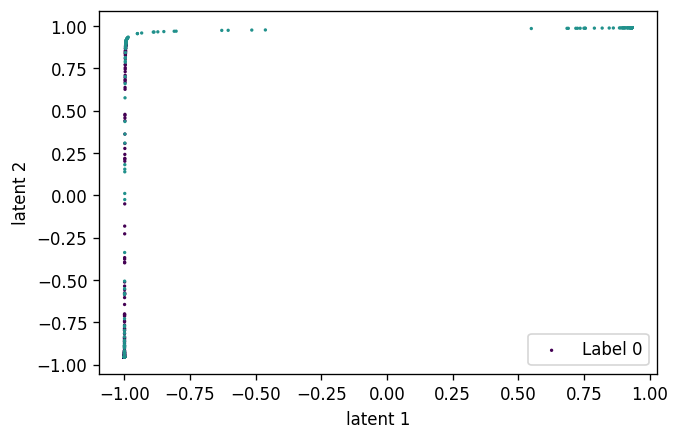

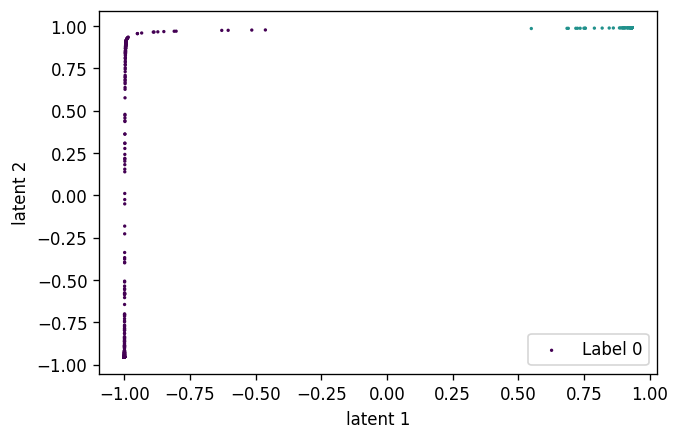

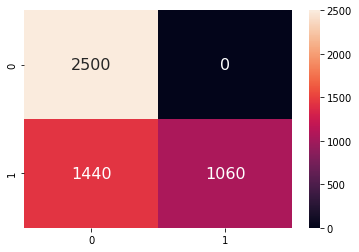

In [ ]:

def decode(x_latent,n_layers):
  y = model.layers[7](  np.array([x_latent])  )
  for i in range(n_layers*2+2,n_layers*4+1):
    y = model.layers[i](y)
  return y

def encode(x,n_layers):
  y = DAE.layers[0]( np.array([x])  )
  for i in range(1,n_layers*2+1):
    y = DAE.layers[i](y)
  return y

if use_testing_dataset:
  tmp_labels = np.zeros([5000])
  tmp_labels[2500:] = 1
  plot_labels = tmp_labels
else:
  plot_labels = labels

latents = encode(X_in,total_encoding_layers).numpy()[0]

c = cm.viridis(plot_labels*.5)
plt.figure(dpi=120)
plt.scatter(latents[:,0],latents[:,1],c=c,s=1,alpha=1)
plt.xlabel('latent 1')
plt.ylabel('latent 2')
plt.legend(['Label 0', 'Label 1'])

from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=2,
                              covariance_type='full')
gmmlabels = gmm.fit_predict(latents)

from sklearn.metrics import accuracy_score, confusion_matrix

c = cm.viridis(gmmlabels*.5)
plt.figure(dpi=120)
plt.scatter(latents[:,0],latents[:,1],c=c,s=1 )
plt.xlabel('latent 1')
plt.ylabel('latent 2')
plt.legend(['Label 0', 'Label 1'])

print(confusion_matrix(plot_labels.flatten(),gmmlabels))
print(accuracy_score(plot_labels.flatten(),gmmlabels))

plt.figure()
conf = confusion_matrix(plot_labels.flatten(),np.abs(gmmlabels ))
cdf = pd.DataFrame(conf, range(2),range(2))

sn.heatmap(cdf, annot=True, annot_kws={"size": 16},fmt='g') # font size

In [ ]:
latents

array([[-0.99937874, -0.99994314],
       [-0.9993786 , -0.99994314],
       [-0.99937874, -0.9999431 ],
       ...,
       [-0.99937874, -0.99994314],
       [-0.9993786 , -0.99994314],
       [-0.99937874, -0.9999431 ]], dtype=float32)

## Conv-AE only


In [ ]:
#@title Denoising Autoencoder

Denoise_dataset = False #@param {type:"boolean"}
use_testing_dataset = False #@param {type:"boolean"}
total_encoding_layers = 3 #@param slider {type:"slider", min:0, max:8, step:1}
center_layer_size = 2 #@param slider {type:"slider", min:0, max:8, step:1}
maxpooling = True 
dropout = False #@param {type:"boolean"}
activation_function = 'tanh' #@param ["relu", "tanh", "sigmoid","linear"]
loss_function = 'MSE' #@param ["MSE", "binary_crossentropy"]

filter_sizes = "64,16,4" #@param {type:"string"}
kernel_sizes = "4,3,2" #@param {type:"string"}
strides = "1,1,1" #@param {type:"string"}
pool_sizes = "4,3,2" #@param {type:"string"}
input_list = lambda strinput: [int(x) for x in strinput.split(',')]
w,h = ssa_time,1

model = Sequential(); model.add(keras.Input(shape=(w, 1))) # input layer



## Encoding layers
for i in range(total_encoding_layers):
  pool_size = input_list(pool_sizes)[i]
  stride_size =  input_list(strides)[i]
  model.add(keras.layers.Conv1D(input_list(filter_sizes)[i], input_list(kernel_sizes)[i], stride_size, activation=activation_function,padding='same'))
  if maxpooling:
    model.add(keras.layers.MaxPooling1D(pool_size= pool_size))


center_shape_in = (int(w/np.prod(input_list(pool_sizes ))) ,int(input_list(filter_sizes)[-1]))
center_shape_flat = center_shape_in[0]*center_shape_in[1]
## center layers
model.add(keras.layers.Flatten())
model.add( keras.layers.Dense(center_layer_size, activation='tanh',))
model.add( keras.layers.Dense(center_shape_flat, activation='tanh',))
model.add(keras.layers.Reshape(center_shape_in ))

## decoding layers layers layers

for i in range(total_encoding_layers-1,-1,-1):
  
  pool_size = input_list(pool_sizes)[i]
  stride_size =  input_list(strides)[i]
  model.add(keras.layers.Conv1D(input_list(filter_sizes)[i], input_list(kernel_sizes)[i], stride_size, activation=activation_function,padding='same'))
  if maxpooling:
    model.add(keras.layers.UpSampling1D(   pool_size ))

model.add(keras.layers.Conv1D(1, input_list(kernel_sizes)[-1],  stride_size, activation=activation_function,padding='same'))
   
#decoded = model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x))
#final classification layer

model.compile(loss=loss_function,
              optimizer='adam',
              metrics=['accuracy'])
DAE = model
if use_testing_dataset: 
  X_in = np.expand_dims(test_dataset,-1)
else:
  X_in = np.expand_dims(int_g_normalized,-1)
Y_in = ssas
if Denoise_dataset:
  x_train, x_val, label_train, label_val = train_test_split(X_in,Y_in,test_size=.2,random_state=42)
else:
  x_train, x_val, label_train, label_val = train_test_split(X_in,X_in,test_size=.2,random_state=42)
DAE.fit(x = x_train, y=label_train,validation_data = (x_val,label_val) ,epochs=40 )


Epoch 1/40
125/125 [==============================] - 10s 21ms/step - loss: 0.0086 - accuracy: 7.8167e-04 - val_loss: 0.0062 - val_accuracy: 7.9767e-04
Epoch 2/40
125/125 [==============================] - 2s 18ms/step - loss: 0.0060 - accuracy: 7.8167e-04 - val_loss: 0.0060 - val_accuracy: 7.9767e-04
Epoch 3/40
125/125 [==============================] - 2s 19ms/step - loss: 0.0059 - accuracy: 7.8167e-04 - val_loss: 0.0060 - val_accuracy: 7.9767e-04
Epoch 4/40
125/125 [==============================] - 2s 19ms/step - loss: 0.0059 - accuracy: 7.8167e-04 - val_loss: 0.0059 - val_accuracy: 7.9767e-04
Epoch 5/40
125/125 [==============================] - 2s 19ms/step - loss: 0.0059 - accuracy: 7.8167e-04 - val_loss: 0.0059 - val_accuracy: 7.9767e-04
Epoch 6/40
125/125 [==============================] - 2s 19ms/step - loss: 0.0059 - accuracy: 7.8167e-04 - val_loss: 0.0059 - val_accuracy: 7.9767e-04
Epoch 7/40
125/125 [==============================] - 2s 19ms/step - loss: 0.0059 - accuracy:

[[  98 2402]
 [2410   90]]
0.0376


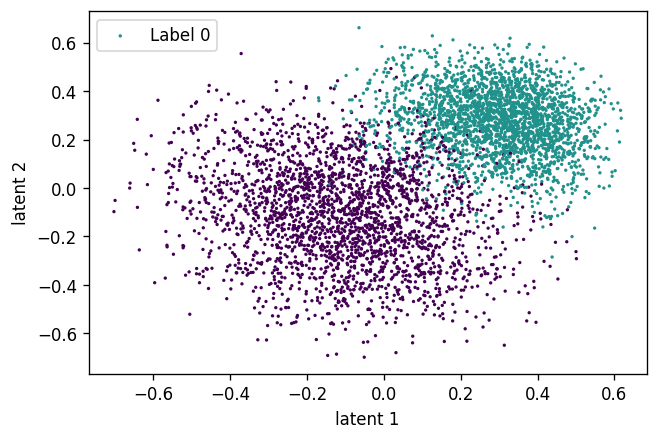

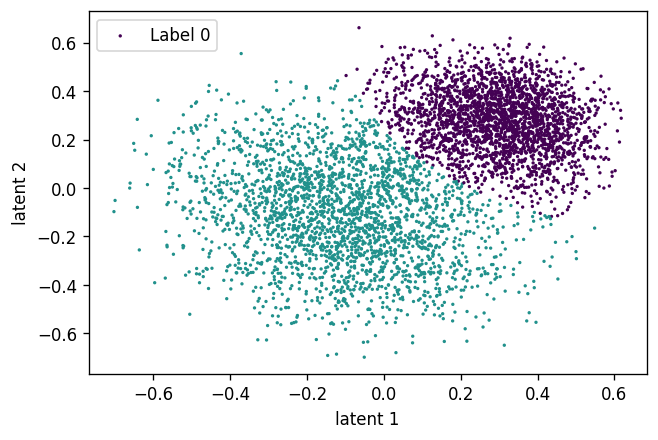

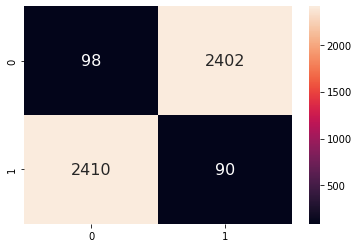

In [ ]:
def decode(x_latent,n_layers):
  y = model.layers[7](  np.array([x_latent])  )
  for i in range(n_layers*2+2,n_layers*4+1):
    y = model.layers[i](y)
  return y

def encode(x,center_layer=7):
  y = DAE.layers[0](x)
  for i in range(1,center_layer+1):
    y = DAE.layers[i](y)
  return y

if use_testing_dataset:
  tmp_labels = np.zeros([5000])
  tmp_labels[2500:] = 1
  plot_labels = tmp_labels
else:
  plot_labels = labels

latents = encode(X_in).numpy()

c = cm.viridis(plot_labels*.5)
plt.figure(dpi=120)
plt.scatter(latents[:,0],latents[:,1],c=c,s=1,alpha=1)
plt.xlabel('latent 1')
plt.ylabel('latent 2')
plt.legend(['Label 0', 'Label 1'])

from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=2,
                              covariance_type='full')
gmmlabels = gmm.fit_predict(latents)

from sklearn.metrics import accuracy_score, confusion_matrix

c = cm.viridis(gmmlabels*.5)
plt.figure(dpi=120)
plt.scatter(latents[:,0],latents[:,1],c=c,s=1 )
plt.xlabel('latent 1')
plt.ylabel('latent 2')
plt.legend(['Label 0', 'Label 1'])

print(confusion_matrix(plot_labels.flatten(),gmmlabels))
print(accuracy_score(plot_labels.flatten(),gmmlabels))

plt.figure()
conf = confusion_matrix(plot_labels.flatten(),np.abs(gmmlabels ))
cdf = pd.DataFrame(conf, range(2),range(2))

sn.heatmap(cdf, annot=True, annot_kws={"size": 16},fmt='g') # font size

(5000, 3000, 64)


In [ ]:

DAE = model
if use_testing_dataset: 
  X_in = np.expand_dims(test_dataset, axis=-1)
else:
  X_in = np.expand_dims(int_g, axis=-1)
Y_in = np.expand_dims(ssas,axis=-1)
if Denoise_dataset:
  x_train, x_val, label_train, label_val = train_test_split(X_in,Y_in,test_size=.2,random_state=42)
else:
  x_train, x_val, label_train, label_val = train_test_split(X_in,X_in,test_size=.2,random_state=42)
DAE.fit(x = x_train, y=label_train,validation_data = (x_val,label_val) ,epochs=25 )

#int_g_denoised = DAE.predict(X_in)[:,:,0]

def decode(x_latent,n_layers):
  y = model.layers[7](  np.array([x_latent])  )
  for i in range(n_layers*2+2,n_layers*4+1):
    y = model.layers[i](y)
  return y

def encode(x,n_layers):
  y = DAE.layers[0]( np.array([x])  )
  for i in range(1,n_layers*2+1):
    y = DAE.layers[i](y)
  return y


#project to latent space
projected_x = encode(x_train[0], total_encoding_layers)
latents = np.empty(  (len(x_train),)+ (projected_x.numpy()[0].shape[0]* projected_x.numpy()[0].shape[1],)  )
for i in range(len(x_train)):
  latents[i] = encode(x_train[i], total_encoding_layers).numpy()[0].flatten()

projected_xval = encode(x_val[0], total_encoding_layers)
latents_val = np.empty(  (len(x_val),)+ (projected_xval.numpy()[0].shape[0]* projected_xval.numpy()[0].shape[1],)  )
for i in range(len(x_val)):
  latents_val[i] = encode(x_val[i], total_encoding_layers).numpy()[0].flatten()

print('compression ratio: %f'% (X_in.shape[1]/len(latents[0])) )

#PCA
pca = PCA(n_components=2, svd_solver='full')
pca.fit(latents)

latent_pca = pca.transform(latents)
latent_pca_val = pca.transform(latents_val)

#GMM
gmm = mixture.GaussianMixture(n_components=2,
                              covariance_type='full')
gmm.fit(latent_pca)
gmmlabels = gmm.fit_predict(latent_pca_val)


c = cm.viridis(gmmlabels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca_val[:,0],latent_pca_val[:,1],c=c,s=3 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])
tmp_labels = np.zeros([5000])
tmp_labels[2500:] = 1
_, _, label_train, label_val = train_test_split(X_in,tmp_labels,test_size=.2,random_state=42)

print(confusion_matrix(label_val.flatten(),gmmlabels))
print(accuracy_score(label_val.flatten(),gmmlabels))


KeyboardInterrupt: ignored

In [ ]:
def get_layer_sizes(input, filter_sizes, kernel_sizes, strides, pool_sizes):
  sizes = []
  sizes.append(input)
  for i in range(len(input_list(filter_sizes) )):
    
    sizes.append(((input_list(filter_sizes)[i] - input_list(filter_sizes)[i] +2*0) /input_list(strides)[i]) +1)
    sizes.append( sizes[-1] / input_list(pool_sizes)[i])
  return sizes

get_layer_sizes(3000, filter_sizes,kernel_sizes, strides, pool_sizes)


[3000, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.5]

In [ ]:
input_list(filter_sizes)[0]

64

In [ ]:
#@title Denoising Autoencoder

Denoise_dataset = False #@param {type:"boolean"}
use_testing_dataset = True #@param {type:"boolean"}
total_encoding_layers = 3 #@param slider {type:"slider", min:0, max:8, step:1}
maxpooling = True 
dropout = False #@param {type:"boolean"}
activation_function = 'relu' #@param ["relu", "tanh", "sigmoid","linear"]
loss_function = 'MSE' #@param ["MSE", "binary_crossentropy"]

filter_sizes = "64,32,16" #@param {type:"string"}
kernel_sizes = "4,3,2" #@param {type:"string"}
strides = "1,1,1" #@param {type:"string"}
pool_sizes = "3,2,2" #@param {type:"string"}
input_list = lambda strinput: [int(x) for x in strinput.split(',')]
w,h = ssa_time,1

model = Sequential(); model.add(keras.Input(shape=(w, 1))) # input layer

## Encoding layers
for i in range(total_encoding_layers):
  pool_size = input_list(pool_sizes)[i]
  stride_size =  input_list(strides)[i]
  model.add(keras.layers.Conv1D(input_list(filter_sizes)[i], input_list(kernel_sizes)[i], stride_size, activation=activation_function,padding='same'))
  if maxpooling:
    model.add(keras.layers.MaxPooling1D(pool_size= pool_size))


## decoding layers layers layers

for i in range(total_encoding_layers-1,-1,-1):
  
  pool_size = input_list(pool_sizes)[i]
  stride_size =  input_list(strides)[i]
  model.add(keras.layers.Conv1D(input_list(filter_sizes)[i], input_list(kernel_sizes)[i], stride_size, activation=activation_function,padding='same'))
  if maxpooling:
    model.add(keras.layers.UpSampling1D(   pool_size ))

model.add(keras.layers.Conv1D(1, input_list(kernel_sizes)[-1],  stride_size, activation=activation_function,padding='same'))
   
#decoded = model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x))
#final classification layer

model.compile(loss=loss_function,
              optimizer='adam',
              metrics=['accuracy'])


DAE = model
if use_testing_dataset: 
  X_in = np.expand_dims(test_dataset, axis=-1)
else:
  X_in = np.expand_dims(int_g, axis=-1)
Y_in = np.expand_dims(ssas,axis=-1)
if Denoise_dataset:
  x_train, x_val, label_train, label_val = train_test_split(X_in,Y_in,test_size=.2,random_state=42)
else:
  x_train, x_val, label_train, label_val = train_test_split(X_in,X_in,test_size=.2,random_state=42)
DAE.fit(x = x_train, y=label_train,validation_data = (x_val,label_val) ,epochs=25 )

#int_g_denoised = DAE.predict(X_in)[:,:,0]

def decode(x_latent,n_layers):
  y = model.layers[7](  np.array([x_latent])  )
  for i in range(n_layers*2+2,n_layers*4+1):
    y = model.layers[i](y)
  return y

def encode(x,n_layers):
  y = DAE.layers[0]( np.array([x])  )
  for i in range(1,n_layers*2+1):
    y = DAE.layers[i](y)
  return y


#project to latent space
projected_x = encode(x_train[0], total_encoding_layers)
latents = np.empty(  (len(x_train),)+ (projected_x.numpy()[0].shape[0]* projected_x.numpy()[0].shape[1],)  )
for i in range(len(x_train)):
  latents[i] = encode(x_train[i], total_encoding_layers).numpy()[0].flatten()

projected_xval = encode(x_val[0], total_encoding_layers)
latents_val = np.empty(  (len(x_val),)+ (projected_xval.numpy()[0].shape[0]* projected_xval.numpy()[0].shape[1],)  )
for i in range(len(x_val)):
  latents_val[i] = encode(x_val[i], total_encoding_layers).numpy()[0].flatten()

print('compression ratio: %f'% (X_in.shape[1]/len(latents[0])) )

#PCA
pca = PCA(n_components=2, svd_solver='full')
pca.fit(latents)

latent_pca = pca.transform(latents)
latent_pca_val = pca.transform(latents_val)

#GMM
gmm = mixture.GaussianMixture(n_components=2,
                              covariance_type='full')
gmm.fit(latent_pca)
gmmlabels = gmm.fit_predict(latent_pca_val)


c = cm.viridis(gmmlabels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca_val[:,0],latent_pca_val[:,1],c=c,s=3 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])
tmp_labels = np.zeros([5000])
tmp_labels[2500:] = 1
_, _, label_train, label_val = train_test_split(X_in,tmp_labels,test_size=.2,random_state=42)

print(confusion_matrix(label_val.flatten(),gmmlabels))
print(accuracy_score(label_val.flatten(),gmmlabels))


Epoch 1/25
125/125 [==============================] - 33s 35ms/step - loss: 0.0240 - accuracy: 6.2375e-04 - val_loss: 0.0040 - val_accuracy: 6.5733e-04
Epoch 2/25
125/125 [==============================] - 4s 30ms/step - loss: 0.0036 - accuracy: 6.6358e-04 - val_loss: 0.0034 - val_accuracy: 6.6400e-04
Epoch 3/25
125/125 [==============================] - 4s 32ms/step - loss: 0.0033 - accuracy: 6.6558e-04 - val_loss: 0.0032 - val_accuracy: 6.6567e-04
Epoch 4/25
125/125 [==============================] - 4s 34ms/step - loss: 0.0031 - accuracy: 6.6558e-04 - val_loss: 0.0031 - val_accuracy: 6.6567e-04
Epoch 5/25
125/125 [==============================] - 4s 30ms/step - loss: 0.0031 - accuracy: 6.6550e-04 - val_loss: 0.0030 - val_accuracy: 6.6600e-04
Epoch 6/25
125/125 [==============================] - 4s 33ms/step - loss: 0.0030 - accuracy: 6.6550e-04 - val_loss: 0.0030 - val_accuracy: 6.6567e-04
Epoch 7/25
125/125 [==============================] - 4s 32ms/step - loss: 0.0030 - accuracy:

NameError: ignored

In [ ]:
DAE.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3000, 64)          320       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 16)           1040      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 250, 16)           5

In [ ]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(test_dataset)

latent_pca = pca.transform(test_dataset)

plt.plot(latent_pca)

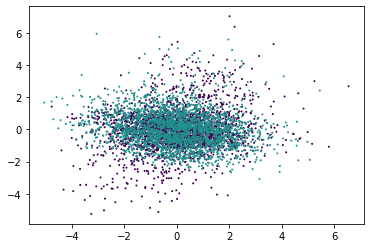

In [ ]:
tmp_labels = np.zeros([5000])
tmp_labels[2500:] = 1
c = cm.viridis(tmp_labels*.5)
plt.scatter(latent_pca[:,0], latent_pca[:,1],c=c,s=1)

In [ ]:
from keras.datasets import mnist
(xt, yt), (xt, yt) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
original_dim = 1*3000
intermediate_dim = 200
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = keras.layers.Dense(latent_dim)(h)
z_log_sigma = keras.layers.Dense(latent_dim)(h)

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = keras.layers.Lambda(sampling)([z_mean, z_log_sigma])


# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = keras.layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
X_in = np.expand_dims(int_g_normalized, axis=-1)
x_train, x_test, label_train, label_val = train_test_split(X_in[:,:,0],X_in[:,:,0],test_size=.2,random_state=42)


#(x_train, y_train), (x_test, y_test) = mnist.load_data()

#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))



Epoch 1/100
125/125 [==============================] - 1s 5ms/step - loss: 2021.1714 - val_loss: 1997.1534
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 1992.9667 - val_loss: 1983.5458
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 1975.7845 - val_loss: 1969.4333
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 1966.8495 - val_loss: 1967.1584
Epoch 5/100
125/125 [==============================] - 0s 4ms/step - loss: 1965.6921 - val_loss: 1966.4264
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 1965.4698 - val_loss: 1965.7404
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 1964.9985 - val_loss: 1965.7469
Epoch 8/100
125/125 [==============================] - 0s 3ms/step - loss: 1964.9220 - val_loss: 1965.7166
Epoch 9/100
125/125 [==============================] - 0s 4ms/step - loss: 1964.8214 - val_loss: 1965.0071
Epoch 10/100
125/125 [===============

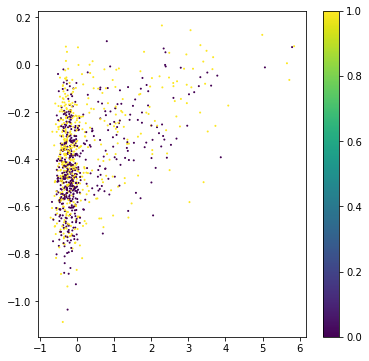

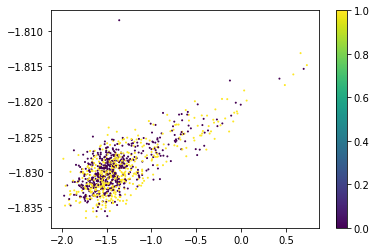

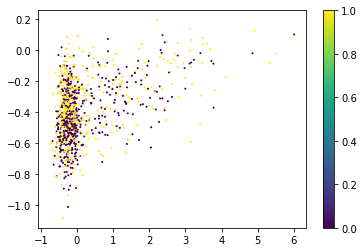

In [ ]:
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(6, 6))

_, _, label_train, label_val = train_test_split(X_in,labels,test_size=.2,random_state=42)

for i in range(3):
  plt.scatter(x_test_encoded[i][:, 0], x_test_encoded[i][:, 1], c=label_val,s=1)
  plt.colorbar()
  plt.show()


In [ ]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [ ]:
encoder.predict(np.array([x_val[0]])  )

[array([[-0.06593764, -0.21260405]], dtype=float32),
 array([[-0.5728251 , -0.70190525]], dtype=float32),
 array([[-0.12064916, -0.24953727]], dtype=float32)]

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 64)           64064       input_19[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 2)            130         dense_51[0][0]                   
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 2)            130         dense_51[0][0]                   
____________________________________________________________________________________________

In [ ]:
len(x_test_encoded[1][:, 0])

1000

In [ ]:
x_test_encoded

[array([[-9.5164403e-05, -6.9822831e-04],
        [-1.8363770e-03, -1.3488029e-03],
        [-2.0669030e-03, -1.3668855e-03],
        ...,
        [ 1.8214971e-02,  1.4721783e-02],
        [ 1.4185726e-03,  1.4097826e-04],
        [-1.2885262e-03, -1.4447115e-03]], dtype=float32),
 array([[-0.00086789, -0.00135819],
        [-0.00077185, -0.00136492],
        [-0.00112953, -0.00140476],
        ...,
        [-0.00562314, -0.00577375],
        [-0.00020129, -0.00111607],
        [-0.00101778, -0.00110338]], dtype=float32),
 array([[-0.02897621,  0.03251054],
        [-0.04568915, -0.05392347],
        [-0.1730792 , -0.06840371],
        ...,
        [-0.00787175, -0.02798458],
        [ 0.03094059,  0.08922604],
        [-0.0347029 ,  0.03133399]], dtype=float32)]

In [ ]:
#@title build_cnn_1D

def build_cnn_model_1D(maxpooling,
                    dropout, 
                    activation_function,
                    loss_function,
                    filter_sizes,
                    kernel_sizes,
                    strides,
                    pool_sizes,
                    dense_neurons,
                    dropout_percent,
                    learning_rate,
                    l2_weight):



  names = ['Intensity','Xsig','Ysig']
  w,h = ssa_time,1
  total_classes = 2
  input_list = lambda strinput: [int(x) for x in strinput.split(',')]
  total_dense_layers = len(input_list(dense_neurons))

  signal_inputs = keras.Input(shape = (w,h), name=  'input_X')


  cnn_outs = []
  all_inputs = []
  #build sub_cnn's
  for signal_num in range(h):
    sub_cnn_input = keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,signal_num],axis=-1) )(signal_inputs)

    #signal_inputs = keras.Input(shape = (w,1), name=  names[signal_num])
    #all_inputs.append(signal_inputs)

    input_list = lambda strinput: [int(x) for x in strinput.split(',')]
    total_convolutional_layers = len(input_list(pool_sizes))
    
    cnn_sub_layers = [ ]
    ## convolutional layers
    for i in range(total_convolutional_layers):
      pool_size = input_list(pool_sizes)[i]
      stride_size =  input_list(strides)[i]
      if i == 0:
        x = keras.layers.Conv1D(input_list(filter_sizes)[i], (input_list(kernel_sizes)[i]  ), (stride_size), activation=activation_function, kernel_regularizer=l2(l2_weight))(sub_cnn_input)
      else:
        x = keras.layers.Conv1D(input_list(filter_sizes)[i], (input_list(kernel_sizes)[i]  ), (stride_size), activation=activation_function, kernel_regularizer=l2(l2_weight) )(x)
      cnn_sub_layers = cnn_sub_layers + [x,]
      if maxpooling:
        x = keras.layers.MaxPooling1D(pool_size=(pool_size))(x)
        cnn_sub_layers = cnn_sub_layers + [x,]
    
    
    cnn_outs.append(keras.layers.Flatten()(x))


  dense_inputs = keras.layers.concatenate(cnn_outs)

  for i in range(total_dense_layers):
    if i == 0:
        x = keras.layers.Dense(input_list(dense_neurons)[i], activation = activation_function)(dense_inputs)
    else:
        x = keras.layers.Dense(input_list(dense_neurons)[i], activation = activation_function)(x)
    if dropout:
      x = keras.layers.Dropout(0.5)(x)

      
  #final classification layer
  if total_classes > 2:
    final_activation = 'softmax'
  else:
    final_activation = 'softmax'

  final_layer = keras.layers.Dense(total_classes, activation = final_activation)(x)

  cnn_model2 = keras.Model(inputs = signal_inputs, outputs= final_layer)
  
  cnn_model2.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return cnn_model2


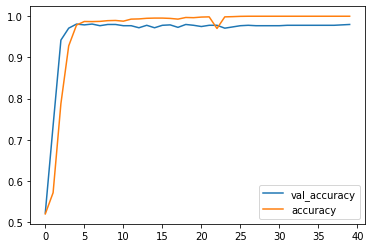

In [ ]:
#@title fit_one_model
cnn_model2 = build_cnn_model_1D(maxpooling= False,
                              dropout = False,
                              dropout_percent = .03,
                              activation_function = 'relu',
                              loss_function = 'categorical_crossentropy',
                              filter_sizes = "15,10,5",
                              kernel_sizes = "2,2,2",
                              strides = "1,1,1",
                              dense_neurons = "200,100,10",
                              pool_sizes = "1,1,1",
                              learning_rate=.0003,
                              l2_weight=.02 )
keras.utils.plot_model(cnn_model2, "multi_input_and_output_model.png", show_shapes=True)

# only training on intensity

x_train, x_val, label_train, label_val = train_test_split(X_in,
                                                            test_labels_onehot,
                                                            test_size=.2,
                                                            random_state=42)

history = cnn_model2.fit(x = x_train, y= label_train,  validation_data=(x_val,label_val),epochs=40, verbose=0 )

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.legend(['val_accuracy','accuracy'])


In [ ]:
DAE.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 3000, 64)          320       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1000, 64)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1000, 32)          6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 500, 16)           1040      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 250, 16)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 250, 16)          

In [ ]:
def encode(x,n_layers):
  y = DAE.layers[0]( np.array([x])  )
  for i in range(1,n_layers*2+1):
    y = DAE.layers[i](y)
  return y


In [ ]:
projected_x = encode(x_train[0], total_encoding_layers)
latents = np.empty(  (len(x_train),)+ (projected_x.numpy()[0].shape[0]* projected_x.numpy()[0].shape[1],)  )
for i in range(len(x_train)):
  latents[i] = encode(x_train[i], total_encoding_layers).numpy()[0].flatten()

projected_xval = encode(x_val[0], total_encoding_layers)
latents_val = np.empty(  (len(x_val),)+ (projected_xval.numpy()[0].shape[0]* projected_xval.numpy()[0].shape[1],)  )
for i in range(len(x_val)):
  latents_val[i] = encode(x_val[i], total_encoding_layers).numpy()[0].flatten()


In [ ]:
projected_x = encode(x_train[0], total_encoding_layers)
latents = np.empty(  (len(x_train),)+ projected_x.numpy()[0].shape  )
for i in range(len(x_train)):
  latents[i] = encode(x_train[i], total_encoding_layers).numpy()[0]

projected_xval = encode(x_val[0], total_encoding_layers)
latents_val = np.empty(  (len(x_val),)+ projected_xval.numpy()[0].shape )
for i in range(len(x_val)):
  latents_val[i] = encode(x_val[i], total_encoding_layers).numpy()[0]

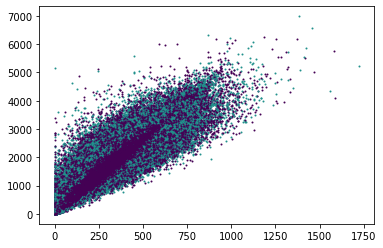

In [ ]:
from matplotlib import cm
c = cm.viridis(labels.flatten()*.5)
for i in range(len(latents)):
  plt.scatter(latents[i,:,0], latents[i,:,1], s=1,c=np.array([c[i]]))


In [ ]:
plt.figure()
for i in range(len(latents)):
  if labels.flatten()[i] < .5:
    plt.scatter(latents[i,:,0], latents[i,:,1], s=1,c=np.array([c[i]]), alpha=.3)

plt.figure()
for i in range(len(latents)):
  if labels.flatten()[i] > .5:
    plt.scatter(latents[i,:,0], latents[i,:,1], s=1,c=np.array([c[i]]), alpha=.3)


IndexError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(latents[0,:,0], latents[0,:,1])
latents[0,:,1]

IndexError: ignored

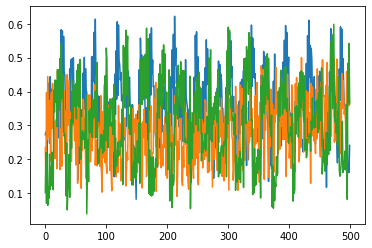

In [ ]:
plt.plot(latents[0:3].T)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
pca.fit(latents)

latent_pca = pca.transform(latents)
latent_pca_val = pca.transform(latents_val)

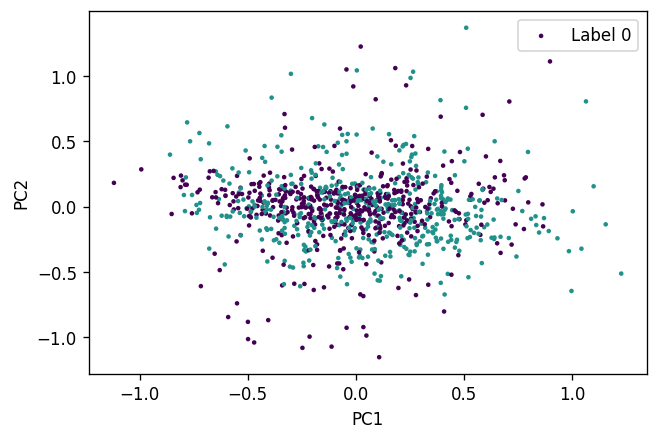

In [ ]:
from matplotlib import cm
c = cm.viridis(label_val.flatten()*.5)
tmp_labels = np.zeros([5000])
tmp_labels[2500:] = 1
_, _, label_train, label_val = train_test_split(X_in,tmp_labels,test_size=.2,random_state=42)
c = cm.viridis(label_val.flatten()*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca_val[:,0],latent_pca_val[:,1],c=c,s=3 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])



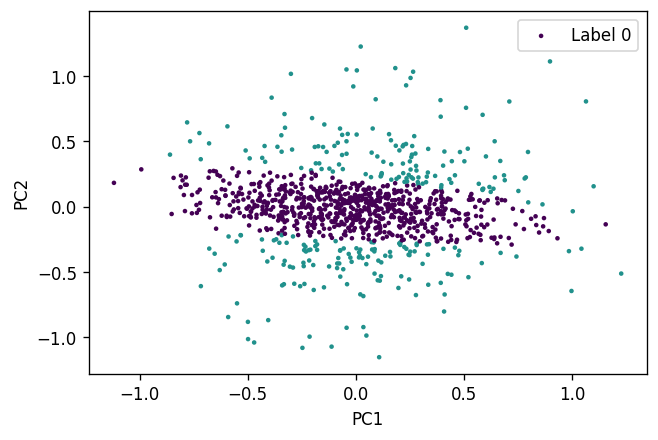

In [ ]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=2,
                              covariance_type='full')

gmm.fit(latent_pca)

gmmlabels = gmm.fit_predict(latent_pca_val)


c = cm.viridis(gmmlabels*.5)
plt.figure(dpi=120)
plt.scatter(latent_pca_val[:,0],latent_pca_val[:,1],c=c,s=3 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['Label 0', 'Label 1'])


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score


print(confusion_matrix(label_val.flatten(),gmmlabels))
print(accuracy_score(label_val.flatten(),gmmlabels))

[[385 115]
 [342 158]]
0.543
